# **Introduction**

The dataset was provided as my Capstone Project being part of the Professional Diploma in Data Analytics at National University of Singapore - Institute of System Science. The project is on the Prediction of Issues from Data Management Tool (JIRA) and was previously written in R.

A real-life scenario was presented with an actual but backdated dataset. Due to data confidentiality, values of the data had underwent data masking. The data had been altered by character shuffling and word substitution or removal. This was done to ensure that sensitive information remains protected while allowing for the analysis and interpretation of the dataset.

# **Background**

The business case that I am working on is for a digital lending company.

A digital lending company, headquartered in Singapore, SmartLoan, aspires to deliver exceptional customer convenience by offering an entirely digital lending experience. To achieve this, the company is actively investing in developing mobile applications and leveraging advanced technologies to personalize customer interactions. Additionally, the company is working towards streamlining the lending process, making it simpler, smarter, and safer for consumers.

Inspiring to be the leader in digital lending with a focus on fully digitalized consumer lending product applications, is a testament to SmartLoan's unwavering dedication to meeting the needs of the consumer. As such, on 18th October 2018, SmartLoan proudly launched the Engagement Lab (eLab) - the first in Southeast Asia - to provide personalized customer service to the clients. With the eLab, we can now have meaningful conversations with our customers across Singapore, Malaysia, Indonesia, Thailand, and Vietnam.

SmartLoan's commitment to providing a seamless digital lending experience with the launched of the eLab, the company is currently facing challenges with the large quantity of issues and bugs arising from the implementation of its systems across the development (DEV), system integration testing (SIT), user acceptance testing (UAT), and production (PROD) environments. These issues are impacting the efficiency and quality of the lending process and ultimately undermining customer satisfaction. Thus, SmartLoan must address these issues to ensure the smooth implementation and operation of its systems across all environments, and to deliver a reliable and satisfying lending experience to its customers.

To overcome the challenges of increasing issues and bugs arising from the implementation of its systems across different environments, SmartLoan must not only focus on addressing the current issues but also predict future trends to prepare for potential issues that may arise. It is crucial for SmartLoan to implement a trend prediction analysis to forecast the number of issues that may arise in the next three months, which will enable the company to proactively plan and allocate resources to mitigate potential issues. This approach will help ensure the effective operation of the lending process and maintain high levels of customer satisfaction.

# **Problem Statement**

The anticipation of the implementation of eLab and digital development across the digital lending services had led to a peak in the total number of projects and issues logged during non-production and production phase in 2018 Q2, as reflected in the project management tool (JIRA). 

Audit findings identified that inconsistency and error made in the inputs by users had negatively impacted the Application Support Team, resulting in a longer resolution time and increased in workload. To address these issues, the Defects Logging and Detection Policy was introduced in December 2019. The primary purpose of the Policy was to provide clarity on the definition of each issue, it's input and processes. The intention aims to reduced the number of issues logged, better classification of issue and therefore reduce resolution time.

# **Business Objective**

The key objective is the effectiveness of the organization's processes and strategies. This business case will evaluate on two key performance indicators: 

1. Effectiveness of Defects Logging and Detection Policy, effective Dec 2019.
    * Was there reduction in number of issues on a monthly basis?
    * Had the time taken to resolve issue reduced?
    

2. Trend prediction of Issues for next 3 months for resources planning. (Prediction of 3 months is due to the short period available for training data)
    * Will there be an increase or decrease in number of issues?
   

# **Data Preprocessing**

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima -q
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error

In [2]:
# Load raw data
data = pd.read_csv('/kaggle/input/prediction-of-issues-and-bugs/Prediction of Issues and Bugs.csv', skipinitialspace=True)

In [3]:
# Display information about dataset
print(data.info())
print("\nThere are nulls in 3 columns: Resolution, Country, Created Date and Resolved. \nOther than ID which is an integer, the rest of the columns are of object (string) data type.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174202 entries, 0 to 174201
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           174202 non-null  int64 
 1   IssueKey     174202 non-null  object
 2   IssueStatus  174202 non-null  object
 3   IssueType    174202 non-null  object
 4   Priority     174202 non-null  object
 5   Resolution   170291 non-null  object
 6   Country      161571 non-null  object
 7   CreatedDate  174202 non-null  object
 8   Resolved     170291 non-null  object
dtypes: int64(1), object(8)
memory usage: 12.0+ MB
None

There are nulls in 3 columns: Resolution, Country, Created Date and Resolved. 
Other than ID which is an integer, the rest of the columns are of object (string) data type.


In [4]:
# Print shape of dataset
print("This dataset contains ", data.shape[0], " rows and ", data.shape[1], " columns")

This dataset contains  174202  rows and  9  columns


In [5]:
# Calculate sparsity factor (cells with null or blank / total cells) 
sparsity = data.isnull().sum().sum() / np.product(data.shape) * 100
print("The sparsity factor for this dataset is", sparsity.round(2), '%.')

# Calculate density factor (cells with data / total cells) 
density = 100 - sparsity
print("The density factor for this dataset is", density.round(2), '%.')

if sparsity > 50:
    print("The dataset is highly sparse, which may affect the accuracy of any analysis performed on it.")
elif sparsity > 10:
    print("The dataset is moderately sparse.")
else:
    print("The dataset is relatively dense, which make it suitable for analysis.")

The sparsity factor for this dataset is 1.3 %.
The density factor for this dataset is 98.7 %.
The dataset is relatively dense, which make it suitable for analysis.


# **Data Cleaning**

The following data cleaning was done;
1. Cleaned column name
2. Removed duplicated rows
3. Split Issue Key
4. Cleaned Country
4. Cleaned Resolution

In [6]:
# Create a dictionary to map original column names to new cloumn names
namechange = {"IssueKey":"Issue Key",
              "IssueStatus":"Issue Status",
              "IssueType":"Issue Type",
              "CreatedDate":"Created Date",
              "Resolved":"Resolved Date"}

# Rename the columns to new column names
data = data.rename(columns=namechange)

# Print the updated column names
print("The data header are now ", list(data.columns))

The data header are now  ['ID', 'Issue Key', 'Issue Status', 'Issue Type', 'Priority', 'Resolution', 'Country', 'Created Date', 'Resolved Date']


In [7]:
# Check for and drop duplicated rows where ID, Issue Key, Environment, Issue Type, and Created Date are identical
if data.duplicated(subset=['ID', 'Issue Key', 'Issue Type', 'Created Date']).sum() == 0:
    # If there are no duplicated rows, print a message and keep the original dataset
    print(f"No duplicated rows found in the dataset.\nDataset remains with {data.shape[0]} rows and {data.shape[1]} columns.")
else:
    # If there are duplicated rows, drop them and print a summary of the action taken
    duplicates = data[data.duplicated(subset=['ID', 'Issue Key', 'Issue Type', 'Created Date'])]
    data = data.drop_duplicates(subset=['ID', 'Issue Key', 'Issue Type', 'Created Date'], keep='first')
    print(f"{duplicates.shape[0]} duplicated rows found and dropped from the dataset.\nAfter dropping duplicated rows, dataset has {data.shape[0]} rows.")


801 duplicated rows found and dropped from the dataset.
After dropping duplicated rows, dataset has 173401 rows.


In [8]:
# split Issue Key to Project Name and Project Issue ID
data['Project Name'], data['Project Issue ID'] = data['Issue Key'].str.split('-', 1).str

# drop Issue Key and Project Issue ID
data = data.drop(['Issue Key','Project Issue ID'],axis=1)

# reorder columns in dataset
data = data[data.columns[[0,8,1,2,3,4,5,6,7]]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


In [9]:
# Calculate % null for each column
null = data[data.columns[data.isnull().any()]].isnull().sum()* 100 / data.shape[0]
null = null.round(2).to_frame('%Null').sort_values('%Null', axis=0, ascending=False)

# Print % null table
print("Percentage of null values in each column: \n")
print(null)

Percentage of null values in each column: 

               %Null
Country         7.26
Resolution      2.23
Resolved Date   2.23


In [10]:
# Clean Country column and drop NAs since they cannot be identified.

# Standarize cities or naming convention
data['Country'].replace({'MY': "Malaysia",
                         'Labuan': "Malaysia",
                         'Los Angeles': 'USA',
                         'New York': 'USA'},
                        inplace=True)

# Drop rows where Country = NA
data = data.dropna(subset=['Country']) 

# Identify countries available in dataset
print("The represented countries in dataset are: \n", data['Country'].unique())

The represented countries in dataset are: 
 ['Singapore' 'Korea' 'Brunei' 'Thailand' 'China' 'Malaysia' 'Indonesia'
 'Japan' 'Hong Kong' 'Myanmar' 'Australia' 'Taiwan' 'Philippines' 'USA'
 'Vietnam' 'Canada' 'India' 'UK']


In [11]:
# Clean Resolution Column

# Fill resolution NAs as open
data['Resolution'].fillna("Open", inplace=True)

# Reclassify resolution into 4 categories
data['Resolution'] = data['Resolution'].replace(to_replace=["Fixed", "Configuration Fix", "Environmental Fix", "Done"],
           value="Fixed/Done")
data['Resolution'] = data['Resolution'].replace(to_replace=["Not a Bug: Change Request", "Duplicate", "Not a Bug", "Incomplete"],
           value="Invalid")
data['Resolution'] = data['Resolution'].replace(to_replace=["Won't Fix", "Won't Do", "Cannot Reproduce"],
           value="Rejected")
data['Resolution'] = data['Resolution'].replace(to_replace=["KIV"],
           value="Open")

# Print the 4 resolution categories
print("Resolution Column had been reclassifed to 4 categories: ", data['Resolution'].unique().tolist())

Resolution Column had been reclassifed to 4 categories:  ['Fixed/Done', 'Rejected', 'Invalid', 'Open']


In [12]:
# Calculate % null for remaining column
null = data[data.columns[data.isnull().any()]].isnull().sum()* 100 / data.shape[0]
null = null.round(2).to_frame('%Null').sort_values('%Null', axis=0, ascending=False)

# Print % null table
print("Percentage of null values in remaining column: \n")
print(null)

Percentage of null values in remaining column: 

               %Null
Resolved Date   2.04


In [13]:
# Convert to datetime
data['Created Date'] = pd.to_datetime(data['Created Date'], format='%d/%m/%Y %H:%M')
data['Resolved Date'] = pd.to_datetime(data['Resolved Date'], format='%d/%m/%Y %H:%M')

# Calculate processing days for each issue
data['Processing Days'] = ''
for index, row in data.iterrows():
    if pd.isnull(row['Resolved Date']):
        data.at[index, 'Processing Days'] = ''
    else:
        data.at[index, 'Processing Days'] = (row['Resolved Date'] - row['Created Date']).days + 1

# When resolve date is null, processing days will be null too. hence, check if there will only be open issues
openissues = data[data['Resolved Date'].isnull()]
print("When Resolved Date is null, the resolution remains as ", openissues['Resolution'].unique())

# Convert the Created Date column to month-year format
data["Period"] = data["Created Date"].dt.strftime("%Y-%m")

When Resolved Date is null, the resolution remains as  ['Open']


# Data Exploration

In [14]:
# Count final number of issues and projects
print("The total number of issues is",len(data), "within", len(data['Project Name'].unique()), "number of projects")

# Count number of closed issues
closedissues = len(data[data['Resolution'] != 'Open'])
closedpercent =  closedissues / len(data) * 100
print("The number of closed issue is", closedissues, "which represents", round(closedpercent, 2), "% of the total issues.")

# Count number of open issues
openissues = len(data[data['Resolution'] == 'Open'])
openpercent =  openissues / len(data) * 100
print("The number of open issue is", openissues, "which represents", round(openpercent, 2), "% of the total issues.")

# Determine top 5 countries with the most number of issues
topcountries = data['Country'].value_counts(normalize=True) * 100
print("The top 5 country based on the number of issues by percentage are:")
print(topcountries.round(2).head(5))

# Assign top 5 countries
top5 = ['Singapore', 'Malaysia', 'Thailand', 'Indonesia', 'Vietnam']

The total number of issues is 160813 within 294 number of projects
The number of closed issue is 154891 which represents 96.32 % of the total issues.
The number of open issue is 5922 which represents 3.68 % of the total issues.
The top 5 country based on the number of issues by percentage are:
Singapore    60.31
Malaysia     17.78
Thailand      7.78
Indonesia     4.04
Vietnam       3.74
Name: Country, dtype: float64



 The proportion for each country: 
              Country %
Singapore        60.31
Malaysia         17.78
Thailand          7.78
Indonesia         4.04
Vietnam           3.74
Hong Kong         2.91
China             2.37
Australia         0.32
Myanmar           0.22
Taiwan            0.22
UK                0.11
Philippines       0.07
Brunei            0.03
India             0.03
Korea             0.02
Japan             0.02
USA               0.02
Canada            0.02


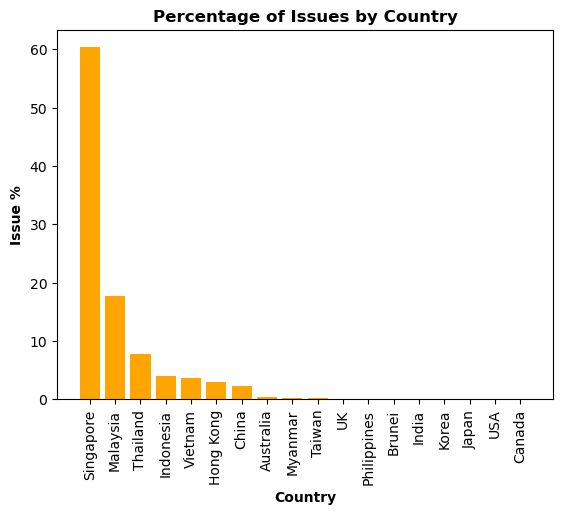

In [15]:
# Calculate the percentage of each country in the Country column
country = data['Country'].value_counts(normalize=True) * 100

# Round percentage to two decimal places and store in a dataframe
country = country.round(2).to_frame('Country %')

# Sort the dataframe in descending order by the "Country %" column
country = country.sort_values('Country %', ascending=False)

# Print the result
print("\n The proportion for each country: \n", country,)

# Create a bar chart
plt.bar(country.index, country['Country %'], color='orange')
plt.title('Percentage of Issues by Country', fontdict={'weight': 'bold'})
plt.xlabel('Country', fontdict={'weight': 'bold'})
plt.ylabel('Issue %', fontdict={'weight': 'bold'})
plt.xticks(rotation=90)
plt.show()

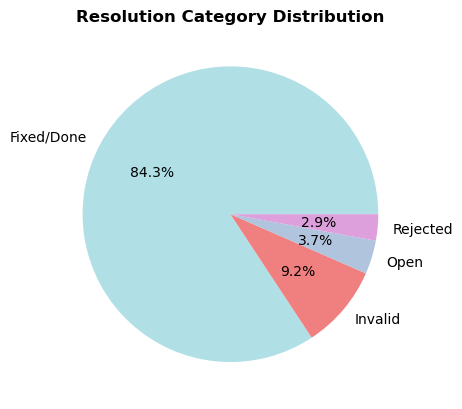

In [16]:
# Draw a pie chart to illustrate distribution
resolution = data['Resolution'].value_counts()
colors = ['powderblue', 'lightcoral', 'lightsteelblue', 'plum']
plt.pie(resolution, labels=resolution.index, autopct='%1.1f%%', colors=colors)
plt.title('Resolution Category Distribution', fontdict={'weight': 'bold'})
plt.show()

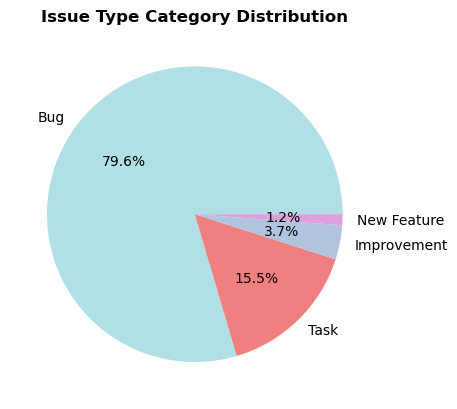

In [17]:
# Since there is no NAs in the Issue Type column
# Draw a pie chart to illustrate distribution

# Count the number of occurrences of each issue type
issuetype = data['Issue Type'].value_counts()

# Assign colors for each issue type category
colors = ['powderblue', 'lightcoral', 'lightsteelblue', 'plum']

# Create a pie chart with percentages
plt.pie(issuetype, labels=issuetype.index, autopct='%1.1f%%', colors=colors)

# Set the title for the pie chart
plt.title('Issue Type Category Distribution', fontdict={'weight': 'bold'})

# Display the pie chart
plt.show()

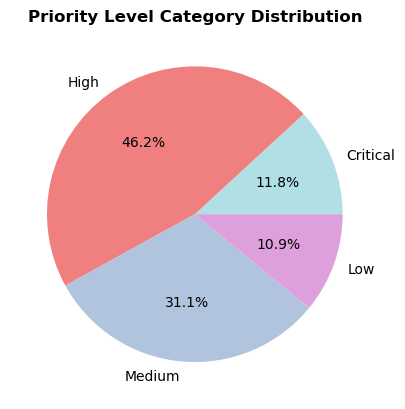

In [18]:
# Since there is no NAs in the Priority column
# Draw a pie chart to illustrate distribution
priority = data['Priority'].value_counts().reindex(['Critical', 'High', 'Medium', 'Low'], axis=1)

# Set colors for the pie chart
colors = ['powderblue', 'lightcoral', 'lightsteelblue', 'plum']

# Plot the pie chart with the values and labels from the priority series
plt.pie(priority, labels=priority.index, autopct='%1.1f%%', colors=colors)

# Add a title to the chart
plt.title('Priority Level Category Distribution', fontdict={'weight': 'bold'})

# Show the chart
plt.show()

# **Data Preparation for Data Modeling**

Divide the entire dataset into two parts based on the year 2016, using it as the threshold.

In [19]:
# Entire dataset from 2016
data_2016 = data[(data['Period'] >= '2016-01') & (data['Created Date'] < '2021-05')]

# Dataset from Jul 2018 to Nov 2019 (17 months)
data_before_17 = data[(data['Period'] >= '2018-07') & (data['Period'] <= '2019-11')]

# Dataset from Dec 2019 to April 2021 (17 months)
data_after_17 = data[(data['Period'] >= '2019-12') & (data['Created Date'] < '2021-05')]

# Dataset from Jul 2018 to April 2021 (34 months)
data_34 = data[(data['Period'] >= '2018-07') & (data['Created Date'] < '2021-05')]

# **Data Exploration - Data after 2016**

**Broad Perspective of the dataset**
    
Number of Issues and Projects illustrated **a peak in the number of issues logged in April 2018**. This is most likely attributed to the testing and development of applications leading up to the launch of eLab in October of that year. As with all launch of new system, it is common to incur more issues, and is expected.

The same peak and trend can be observed with the number of projects, this is evident of a **positive correlation between number of issues and projects**. This relationship has been statistically proven by correlation coefficient of positive 0.8 and a regression model with R-Squared value of 0.642. This indicate an approximate 64.2% of the variation in the number of issue (dependent variable) can be explained by the number of project (independent variable). In order words, with every increase in project, it leads to an increase in approximately 73 issue and a p-value of less than 0.000.

Following the successful launched of eLab, in October 2018, **both the number of issues and projects showed a declining trend**. Nonetheless, there was a noticeable increase in the number of issues in Q4 2020. Further investigation revealed that there had been a system migration project for one of the software application taking place in Malaysia. This observation was supported by the plot of Number of Issues by Countries, where Malaysia was the only country which had an **increased peak in Q4 2020**, while the other countries was on a decreasing trend.

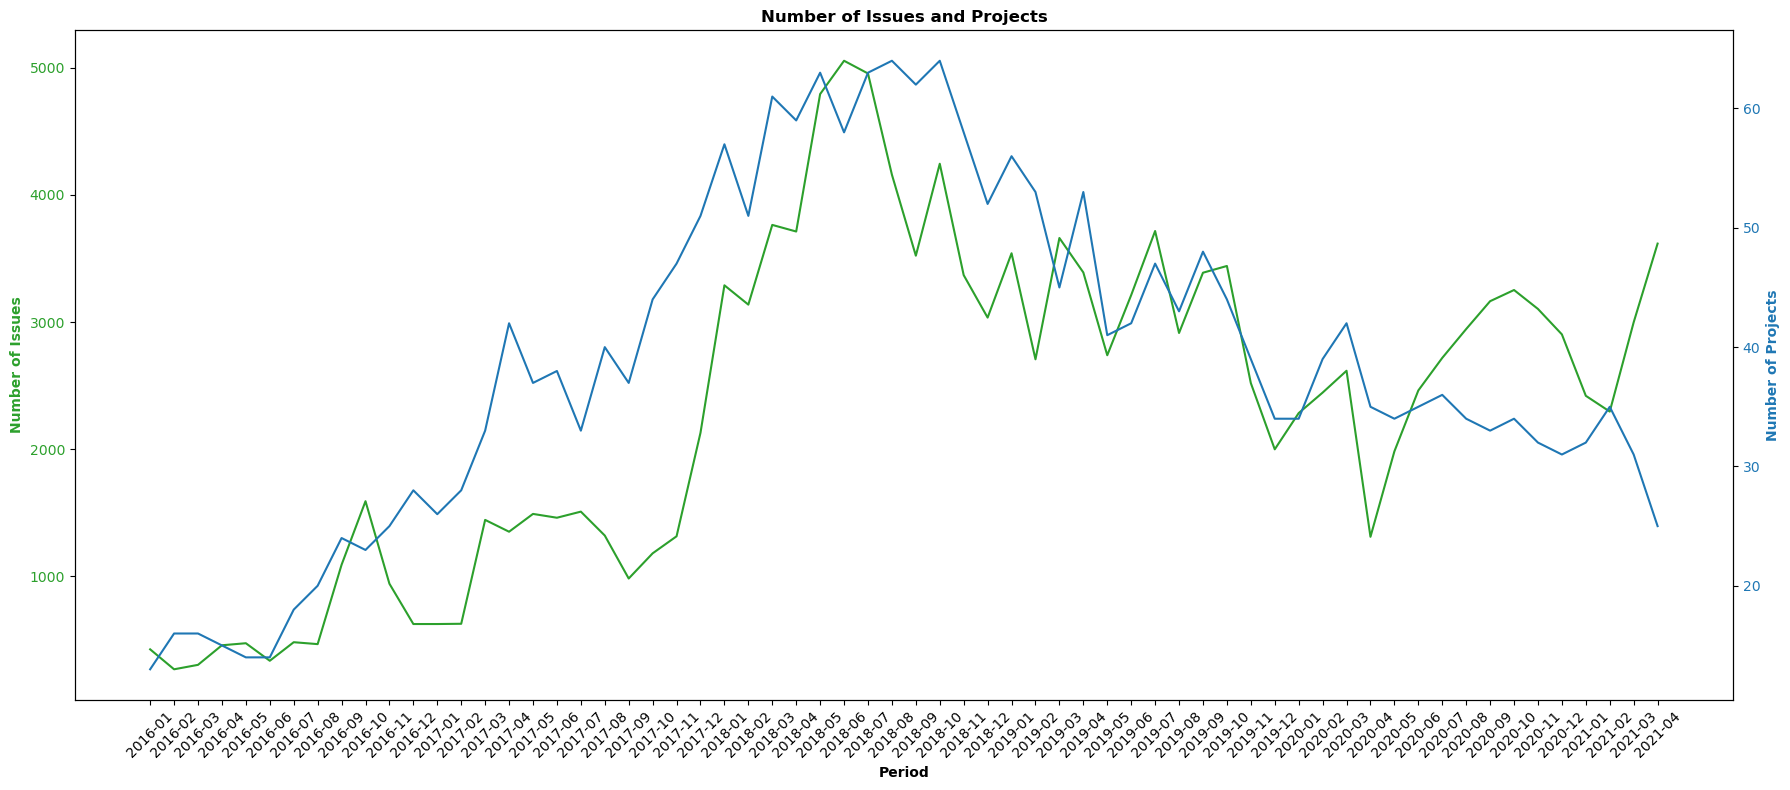

In [20]:
# Group the data by period and get the size of each group
data_agg = data_2016.groupby('Period').agg({'ID': 'count', 'Project Name': 'nunique'}).reset_index()

# Plot line graph for count of issues
fig, ax1 = plt.subplots(figsize=(18, 8))

color = 'tab:green'
ax1.set_xlabel('Period', fontdict={'weight': 'bold'})
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Number of Issues', color=color,  fontdict={'weight': 'bold'})
ax1.plot(data_agg['Period'], data_agg['ID'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Number of Issues and Projects', fontdict={'weight': 'bold'})

# Plot line graph for mean processing days
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Number of Projects', color=color,  fontdict={'weight': 'bold'})
ax2.plot(data_agg['Period'], data_agg['Project Name'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [21]:
# Calculate correlation coefficient between number of issues and project
corr_coeff = data_agg['ID'].corr(data_agg['Project Name'])
print('Correlation coefficient between number of issues and number of unique projects:', corr_coeff.round(2))

# measures the strength and direction of the linear relationship between two variables. It ranges from -1 to 1, where -1 represents a perfect negative correlation, 0 represents no correlation, and 1 represents a perfect positive correlation.

Correlation coefficient between number of issues and number of unique projects: 0.8


In [22]:
# Group the data by period and get the size of each group
data_agg = data_2016.groupby('Period').agg({'ID': 'count', 'Project Name': 'nunique'}).reset_index()

# Define X and Y variables
X = data_agg['Project Name']
Y = data_agg['ID']

# Add constant to X
X = sm.add_constant(X)

# Create linear regression model and fit
model = sm.OLS(Y, X)
results = model.fit()

# Print the regression results summary
print(results.summary())

# Perform Shapiro-Wilk test for residual of linear regression model
stat, p = stats.shapiro(results.resid)
print('\033[1;4;33m' +  '\nShapiro-Wilk Test Results:\n' + '\033[0m')
print('Statistic:', stat)
print('p-value:', p)
if p > 0.05:
    print('The residuals are normally distributed.')
else:
    print('The residuals are not normally distributed.')

                            OLS Regression Results                            
Dep. Variable:                     ID   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     111.3
Date:                Mon, 08 May 2023   Prob (F-statistic):           1.80e-15
Time:                        04:28:29   Log-Likelihood:                -515.59
No. Observations:                  64   AIC:                             1035.
Df Residuals:                      62   BIC:                             1039.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -495.7594    285.587     -1.736   

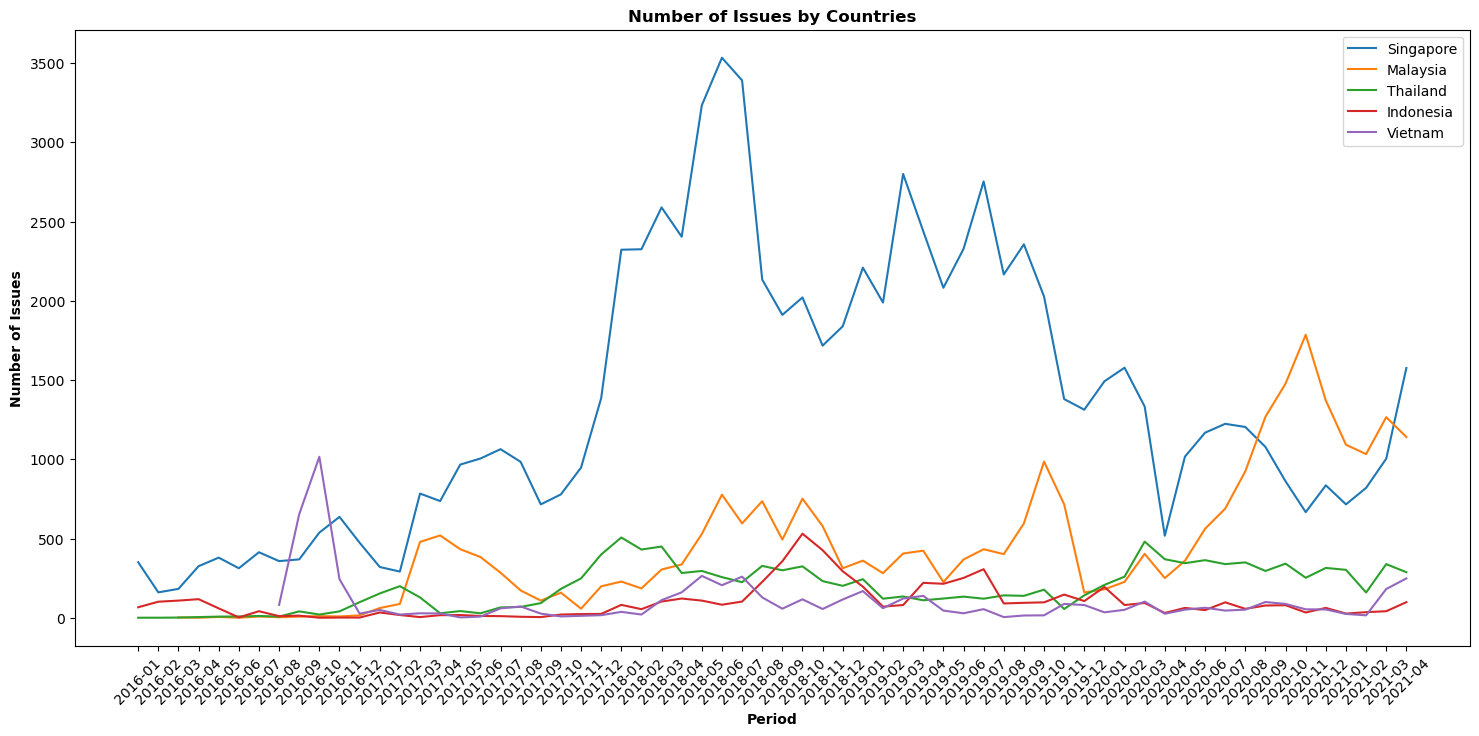

In [23]:
# Filter the data by the countries of interest
data_2016_countries = data_2016[data_2016['Country'].isin(top5)]

# Group the filtered data by period and get the size of each group
data_agg = data_2016_countries.groupby(['Period', 'Country']).agg({'ID': 'count'}).reset_index()

# Plot line graph for count of issues for each country
fig, ax = plt.subplots(figsize=(18, 8))

for country in top5:
    df_country = data_agg[data_agg['Country'] == country]
    ax.plot(df_country['Period'], df_country['ID'], label=country)

ax.set_xlabel('Period', fontdict={'weight': 'bold'})
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Number of Issues', fontdict={'weight': 'bold'})
ax.set_title('Number of Issues by Countries', fontdict={'weight': 'bold'})
ax.legend()

plt.show()

# **Reduction in Monthly Issues**

**Refering to Business Objective**

1. Effectiveness of Defects Logging and Detection Policy, effective Dec 2019.
    * Was there reduction in number of issues on a monthly basis?

Mean number of issues, on a monthly basis, showed an decreasing trend, 17 months post policy implementation. This had been supported by the plot of Number of Issues (17 Months before Policy) and Number of Issues (17 Months after Policy). To determine the significant, a t-test had been conducted to compare the mean number of issues pre and post policy implementation.

* **Null hypothesis:** There is no significant difference in mean
* **Alternative hypothesis:** The decrease in mean after policy implementation is significant

The t-statistic of 4.08 and p-value of 0.00028 concluded that there was a significant difference in the mean number of issues pre and post policy implementation. The reduction in number of issues did not happen by chance and was likely attributed to the policy.

A histogram, Distribution of Number of Issues, had been plotted for a visualisation on the distribution of number of issues.

From a business perspective, the effectiveness of the policy in terms of reduction of number of issues can lead to cost saving, due to better manpower allocation, and improve customer satisfaction due to shorter resolution time. The effectiveness of the policy in terms of processing time of issues shall be evaluated subsequently.

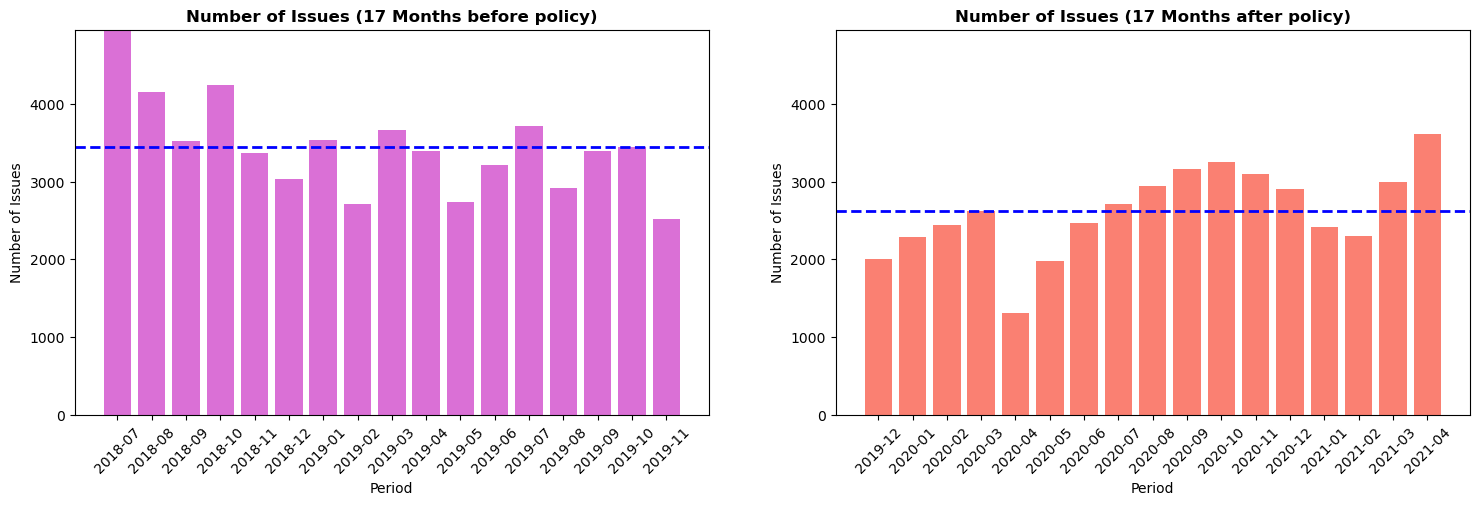

Mean before policy:  3442
Mean after policy:  2618
Reduction:  31.44 %


In [24]:
# Group the data by period and get the size of each group
grouped_data_before_17 = data_before_17.groupby(['Period']).size()
grouped_data_after_17 = data_after_17.groupby(['Period']).size()

# Illustrate data with two subplots, side by side, for easy comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# Find the maximum value between the two datasets so as to have an accurate comparison, visually.
max_y_value = max(max(grouped_data_before_17.values), max(grouped_data_after_17.values))

# Create a bar chart of the grouped data for before 2017
ax1.bar(grouped_data_before_17.index, grouped_data_before_17.values, color='orchid')
ax1.set_xlabel('Period')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Number of Issues')
ax1.set_title('Number of Issues (17 Months before policy)', fontdict={'weight': 'bold'})
ax1.set_ylim([0, max_y_value])

# Create a bar chart of the grouped data for after 2017
ax2.bar(grouped_data_after_17.index, grouped_data_after_17.values, color='salmon')
ax2.set_xlabel('Period')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Number of Issues')
ax2.set_title('Number of Issues (17 Months after policy)', fontdict={'weight': 'bold'})
ax2.set_ylim([0, max_y_value]) 

# Calculate the mean value for each group
mean_before_17 = np.mean(grouped_data_before_17.values)
mean_after_17 = np.mean(grouped_data_after_17.values)

# Add mean line to the bar chart
ax1.axhline(mean_before_17, color='blue', linestyle='--', linewidth=2)
ax2.axhline(mean_after_17, color='blue', linestyle='--', linewidth=2)

# Display the chart
plt.show()

# Print mean value for pre and post policy
print("Mean before policy: ", mean_before_17.astype(int))
print("Mean after policy: ", mean_after_17.astype(int))
print("Reduction: ", (((mean_before_17 - mean_after_17) / mean_after_17) * 100).round(2), "%")

The T-Test for the significance between the mean number of issues between before and after policy implementation:
t-statistic: 4.08
p-value: 0.00028


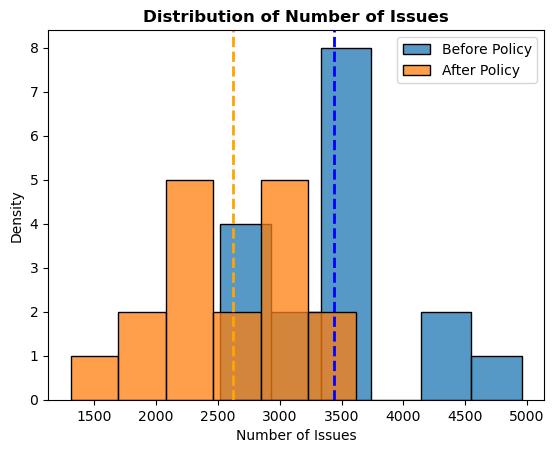

In [25]:
# define the two samples (before and after policy)
before = data_before_17.groupby(['Period']).size().values
after = data_after_17.groupby(['Period']).size().values

# Calculate the means of the samples
mean_before = before.mean()
mean_after = after.mean()

# Calculate the standard deviations of the samples
std_before = before.std()
std_after = after.std()

# Calculate the number of observations in the samples
n_before = len(before)
n_after = len(after)

# Calculate the degrees of freedom for the t-test
degfree = n_before + n_after - 2

# Calculate the standard error of the difference in means
se_diff = ((std_before**2 / n_before) + (std_after**2 / n_after))**0.5

# Calculate the t-statistic and p-value for the two-sample t-test
t_stat, p_value = stats.ttest_ind(before, after, equal_var=False)

# Print the results of the t-test
print("The T-Test for the significance between the mean number of issues between before and after policy implementation:")
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.5f}")

# Plot the distribution of the before policy data
sns.histplot(before, label="Before Policy")

# Plot the distribution of the after policy data
sns.histplot(after, label="After Policy")

# Add a vertical line for the mean of the before policy data
plt.axvline(mean_before, color='blue', linestyle='--', linewidth=2)

# Add a vertical line for the mean of the after policy data
plt.axvline(mean_after, color='orange', linestyle='--', linewidth=2)

# Set the title and labels
plt.title("Distribution of Number of Issues", fontdict={'weight': 'bold'})
plt.xlabel("Number of Issues")
plt.ylabel("Density")

# Add a legend
plt.legend()

# Display the plot
plt.show()

> ***Updates after capstone project completion***
> 
> Simply looking into number of issues cannot determine if the policy is effective in contributing to the decrease in issues. There might be other contributing factors which had not been considered. Given the high correlation coefficient between number of issues and projects, it is necessary to investigate this relationship. Furthermore, increasing in digitalization adoption and customer base, the number of users utilizing the platform/system will increase, which ought to be taken into account. However, since we do not have insights on the users, we will evaluate the effect of number of projects in the trend for issues after policy implementation by normalizing the number of issues by project number within the same period.
> 
> The bar plot of Normalized Number of Issues by Project (17 Months before Policy) had a lower mean and overall trend as compared to Normalized Number of Issues by Project (17 Months after Policy). This is a reflection on a higher number of issues per project post policy implementation.
> 
> In order to determine if the increase in normalized number of issues after policy implementation is significant, a t-test had been conducted to compare the mean in normalized number of issues before and after policy implementation.
> 
> * **Null hypothesis:** There is no significant difference
> * **Alternative hypothesis:** The increase in mean after policy implementation is significant
> 
> The results was a t-statistic of -1.86 and p-value of 0.07675 concluding the failure to reject the null hypothesis. This suggests that the increased in normalized number of issues post policy implementation may not be statistically signifcant with 92.325% confidence.
> 
> Nonetheless, considering that it falls short of 2.675% to justify a significant difference in the increased in normalized number of issues, it will be meaningful to understand if impact of the increased in number of users contributed to the increase.
> 
> It is therefore non conclusive that the business objective of the effectiveness of the policy has not been met. Further investigation on factors like the user data will be needed to determine the final effectiveness.

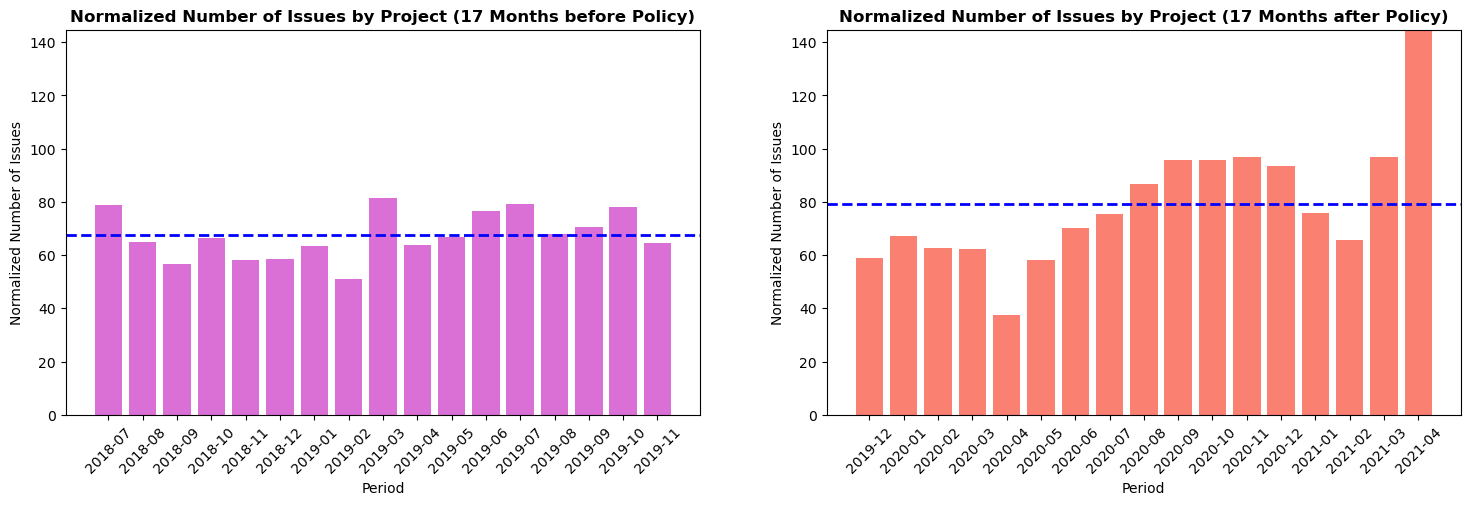

In [26]:
# Group the data by period and get the size of each group
grouped_data_before_17 = data_before_17.groupby(['Period']).agg({'ID': 'count', 'Project Name': 'nunique'})
grouped_data_after_17 = data_after_17.groupby(['Period']).agg({'ID': 'count', 'Project Name': 'nunique'})

# Calculate the normalized number of issues for each period
normalized_before_17 = grouped_data_before_17['ID'] / grouped_data_before_17['Project Name']
normalized_after_17 = grouped_data_after_17['ID'] / grouped_data_after_17['Project Name']

# Illustrate data with two subplots, side by side, for easy comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# Find the maximum value between the two datasets so as to have an accurate comparison, visually.
max_y_value = max(max(normalized_before_17.values), max(normalized_after_17.values))

# Create a bar chart of the normalized data for before 2017
ax1.bar(normalized_before_17.index, normalized_before_17.values, color='orchid')
ax1.set_xlabel('Period')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Normalized Number of Issues')
ax1.set_title('Normalized Number of Issues by Project (17 Months before Policy)', fontdict={'weight': 'bold'})
ax1.set_ylim([0, max_y_value])

# Create a bar chart of the normalized data for after 2017
ax2.bar(normalized_after_17.index, normalized_after_17.values, color='salmon')
ax2.set_xlabel('Period')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Normalized Number of Issues')
ax2.set_title('Normalized Number of Issues by Project (17 Months after Policy)', fontdict={'weight': 'bold'})
ax2.set_ylim([0, max_y_value]) 

# Calculate the mean value for each group
mean_before_17 = np.mean(normalized_before_17.values)
mean_after_17 = np.mean(normalized_after_17.values)

# Add mean line to the bar chart
ax1.axhline(mean_before_17, color='blue', linestyle='--', linewidth=2)

# Add mean line to the bar chart
ax2.axhline(mean_after_17, color='blue', linestyle='--', linewidth=2)

# Display the chart
plt.show()


The T-Test for the significance between the normalized mean number of issues between before and after policy implementation:
t-statistic: -1.86
p-value: 0.07675


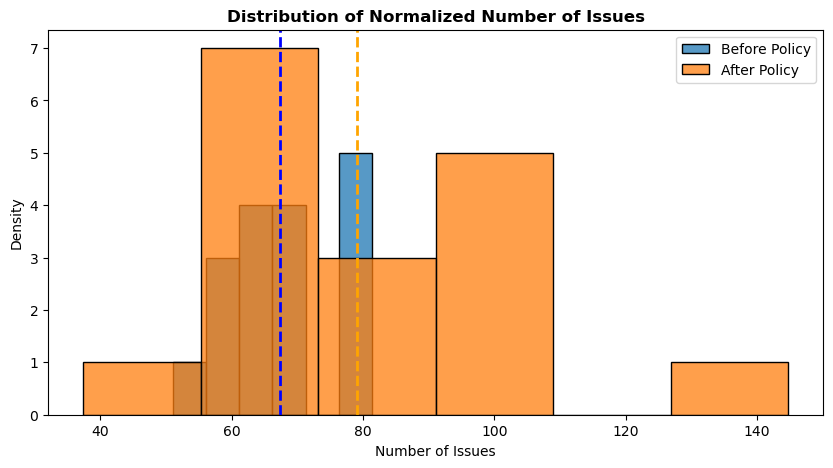

In [27]:
# Group the data by period and get the size of each group
grouped_data_before_17 = data_before_17.groupby(['Period']).agg({'ID': 'count', 'Project Name': 'nunique'})
grouped_data_after_17 = data_after_17.groupby(['Period']).agg({'ID': 'count', 'Project Name': 'nunique'})

# Calculate the normalized number of issues for each period
normalized_before_17 = grouped_data_before_17['ID'] / grouped_data_before_17['Project Name']
normalized_after_17 = grouped_data_after_17['ID'] / grouped_data_after_17['Project Name']

# Calculate the means of the samples
mean_before = normalized_before_17.mean()
mean_after = normalized_after_17.mean()

# Calculate the standard deviations of the samples
std_before = normalized_before_17.std()
std_after = normalized_after_17.std()

# Calculate the number of observations in the samples
n_before = len(normalized_before_17)
n_after = len(normalized_after_17)

# Calculate the degrees of freedom for the t-test
degfree = n_before + n_after - 2

# Calculate the standard error of the difference in means
se_diff = ((std_before**2 / n_before) + (std_after**2 / n_after))**0.5

# Calculate the t-statistic and p-value for the two-sample t-test
t_stat, p_value = stats.ttest_ind(normalized_before_17, normalized_after_17, equal_var=False)

# Print the results of the t-test
print("The T-Test for the significance between the normalized mean number of issues between before and after policy implementation:")
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.5f}")

# Create a figure with a specific size
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the distribution of the pre and post policy data
sns.histplot(normalized_before_17, label="Before Policy")
sns.histplot(normalized_after_17, label="After Policy")

# Add a vertical line for the mean of the pre and post policy
plt.axvline(mean_before, color='blue', linestyle='--', linewidth=2)
plt.axvline(mean_after, color='orange', linestyle='--', linewidth=2)

# Set the title and labels
plt.title("Distribution of Normalized Number of Issues", fontdict={'weight': 'bold'})
plt.xlabel("Number of Issues")
plt.ylabel("Density")

# Add a legend
plt.legend()

# Display the plot
plt.show()

# **Reduction in Processing Time**

Refering to business objective

1. Effectiveness of Defects Logging and Detection Policy, effective Dec 2019.
    * Had the time taken to resolve issue reduced?
    
It can be observed from the plot of Average Processing Days (17 Months before policy) and Average Processing Days (17 Months after policy) that there was a decreasing trend in terms of processing time for closed issues. The mean for period of 17 months pre and post policy implementation also showed that there was a decrease. A t-test was further used to prove the statistical significance post policy implementation.

* **Null hypothesis:** There is no significant difference in mean
* **Alternative hypothesis:** The decrease in mean after policy implementation is significant

Based on the t-statistic of 3.58 and a p-value of 0.00126, it had been concluded that there was a significant difference in the mean average processing days before and after the policy was implemented. The t-statistic of 3.58 indicated that the difference in means was large relative to the variability within each group. The p-value of 0.00126 indicated that the probability of observing such a large difference in means by chance was very low, and therefore, the null hypothesis is rejected, the means are equal.

A histogram, Distribution of Average Processing Days, had been plotted for a visualisation on the distribution of processing days.

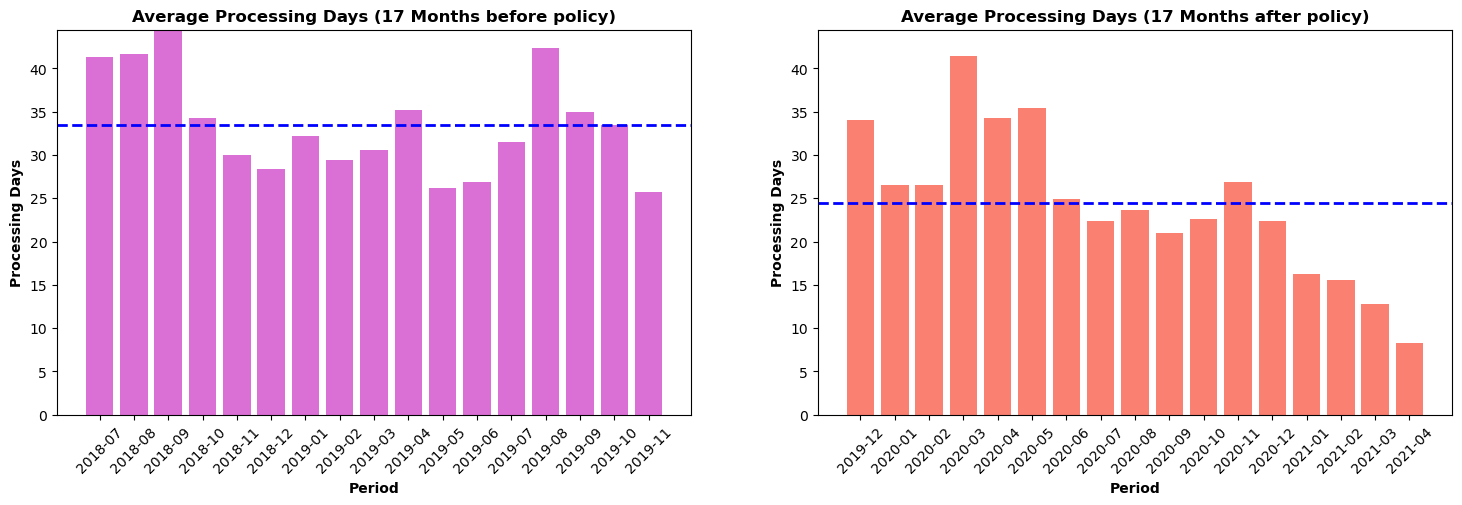

Mean before policy:  33.46
Mean after policy:  24.4
Reduction:  37.1 %


In [28]:
# Group the data by period and get the size of each group
grouped_data_before_17 = data_before_17.loc[data_before_17['Resolution'] != 'Open'].groupby(['Period'])['Processing Days'].mean()
grouped_data_after_17 = data_after_17.loc[data_after_17['Resolution'] != 'Open'].groupby(['Period'])['Processing Days'].mean()

# Illustrate data with two subplots, side by side, for easy comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# Find the maximum value between the two datasets so as to have an accurate comparison, visually.
max_y_value = max(max(grouped_data_before_17.values), max(grouped_data_after_17.values))

# Create a bar chart of the grouped data for before 2017
ax1.bar(grouped_data_before_17.index, grouped_data_before_17.values, color='orchid')
ax1.set_xlabel('Period', fontdict={'weight': 'bold'})
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Processing Days', fontdict={'weight': 'bold'})
ax1.set_title('Average Processing Days (17 Months before policy)', fontdict={'weight': 'bold'})
ax1.set_ylim([0, max_y_value])

# Create a bar chart of the grouped data for after 2017
ax2.bar(grouped_data_after_17.index, grouped_data_after_17.values, color='salmon')
ax2.set_xlabel('Period', fontdict={'weight': 'bold'})
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Processing Days', fontdict={'weight': 'bold'})
ax2.set_title('Average Processing Days (17 Months after policy)', fontdict={'weight': 'bold'})
ax2.set_ylim([0, max_y_value]) 

# Calculate the mean value for each group
mean_before_17 = np.mean(grouped_data_before_17.values)
mean_after_17 = np.mean(grouped_data_after_17.values)

# Add mean line to the bar chart
ax1.axhline(mean_before_17, color='blue', linestyle='--', linewidth=2)

# Add mean line to the bar chart
ax2.axhline(mean_after_17, color='blue', linestyle='--', linewidth=2)

# Display the chart
plt.show()

# Print mean value for pre and post policy
print("Mean before policy: ", mean_before_17.round(2))
print("Mean after policy: ", mean_after_17.round(2))
print("Reduction: ", (((mean_before_17 - mean_after_17) / mean_after_17) * 100).round(2), "%")

The T-Test for the significance between the normalized mean number of issues between pre and post policy implementation:
t-statistic: 3.58
p-value: 0.00126


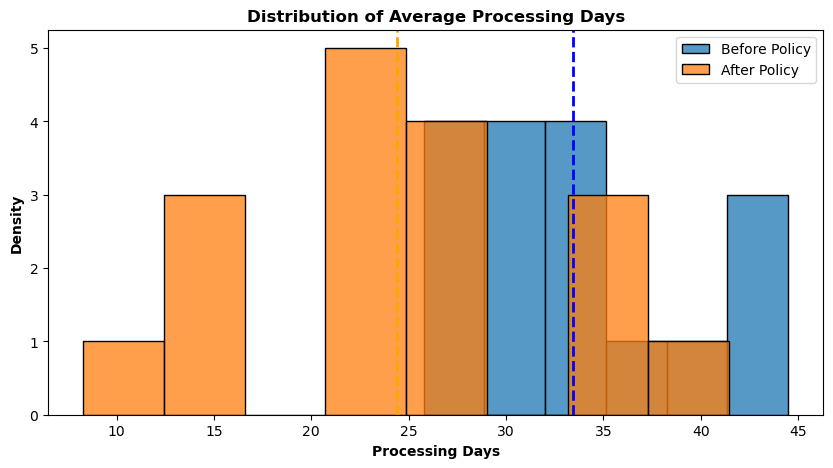

In [29]:
# Group the data by period and get the size of each group
grouped_data_before_17 = data_before_17.loc[data_before_17['Resolution'] != 'Open'].groupby(['Period'])['Processing Days'].mean()
grouped_data_after_17 = data_after_17.loc[data_after_17['Resolution'] != 'Open'].groupby(['Period'])['Processing Days'].mean()

# Calculate the means of the samples
mean_before = grouped_data_before_17.mean()
mean_after = grouped_data_after_17.mean()

# Calculate the standard deviations of the samples
std_before = grouped_data_before_17.std()
std_after = grouped_data_after_17.std()

# Calculate the number of observations in the samples
n_before = len(grouped_data_before_17)
n_after = len(grouped_data_after_17)

# Calculate the degrees of freedom for the t-test
degfree = n_before + n_after - 2

# Calculate the standard error of the difference in means
se_diff = ((std_before**2 / n_before) + (std_after**2 / n_after))**0.5

# Calculate the t-statistic and p-value for the two-sample t-test
t_stat, p_value = stats.ttest_ind(grouped_data_before_17, grouped_data_after_17, equal_var=False)

# Print the results of the t-test
print("The T-Test for the significance between the normalized mean number of issues between pre and post policy implementation:")
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.5f}")

# Create a figure with a specific size
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the distribution of the pre and post policy data
sns.histplot(grouped_data_before_17, label="Before Policy")
sns.histplot(grouped_data_after_17, label="After Policy")

# Add a vertical line for the mean of the pre and post policy data
plt.axvline(mean_before, color='blue', linestyle='--', linewidth=2)
plt.axvline(mean_after, color='orange', linestyle='--', linewidth=2)

# Set the title and labels
plt.title("Distribution of Average Processing Days", fontdict={'weight': 'bold'})
plt.xlabel("Processing Days", fontdict={'weight': 'bold'})
plt.ylabel("Density", fontdict={'weight': 'bold'})

# Add a legend
plt.legend()

# Display the plot
plt.show()

It was established that there was a general reduction in the average processing days. Further analysis was conducted to focus on the Issue Type and Priority Level.

Through the analysis, it was found that the implementation of policy had led to a significant impact on reducting processing time for Issue Type: New Features and Improvements by 57.93 days and 40.65 days respectively. This would have resulted in a better user experience for the customers and reduced resources.

Subsequent observations revealed that isses with low and medium priority level generally take longer to resolve than high and critical levels. This outcome is desirable to the stakeholders as the priority severity increases with a increase in impact and consequence. With the implementation of the policy, the largest improvement in processing time was observed for medium priority at 31.13%.

Suggestions for improvement:
1. Optimize processing time for Task and Bugs to improve overall efficiency.
2. Evaluate task of Low and Medium priority to reduce risk in misjudgement resulting in avoidable impact.

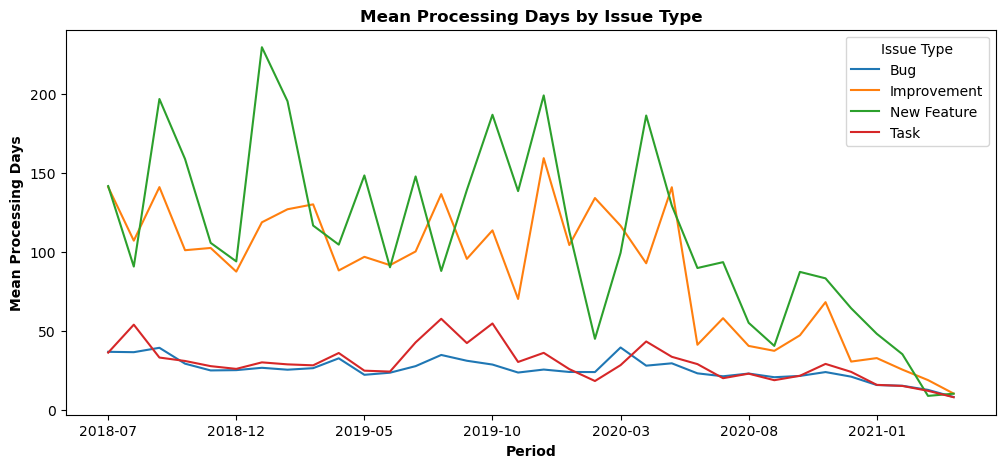

In [30]:
# Group the data by period and issue type and get the mean processing days for each group
grouped_data = data_34.loc[data_34['Resolution'] != 'Open'].groupby(['Period', 'Issue Type'])['Processing Days'].mean()

# Reshape the data to create a table with the mean processing days for each period and issue type
table_data = grouped_data.unstack(level=-1)

# Create a line plot of the mean processing times for each period and issue type
table_data.plot(kind='line', figsize=(12, 5))

# Add a title and axis labels to the plot
plt.title('Mean Processing Days by Issue Type', fontdict={'weight': 'bold'})
plt.xlabel('Period', fontdict={'weight': 'bold'})
plt.ylabel('Mean Processing Days', fontdict={'weight': 'bold'})

# Display the plot
plt.show()

In [31]:
# Group the data by period and get the mean processing days for each group
grouped_before_17 = data_before_17.loc[(data_before_17['Resolution'] != 'Open') & (data_before_17['Issue Type'] == 'New Feature')].groupby(['Period', 'Issue Type'])['Processing Days'].mean()
grouped_after_17 = data_after_17.loc[(data_after_17['Resolution'] != 'Open') & (data_after_17['Issue Type'] == 'New Feature')].groupby(['Period', 'Issue Type'])['Processing Days'].mean()

# Calculate the mean value for each group
mean_before_17 = np.mean(grouped_before_17.values)
mean_after_17 = np.mean(grouped_after_17.values)
change = mean_before_17 - mean_after_17
changepercent = change / (mean_before_17 + mean_after_17) * 100
print(f"The reduction percentage in average processing time after policy implementation are; \nNew Feature:  {change:.2f} days (", changepercent.round(2), "%)")

# Group the data by period and get the mean processing days for each group
grouped_before_17 = data_before_17.loc[(data_before_17['Resolution'] != 'Open') & (data_before_17['Issue Type'] == 'Improvement')].groupby(['Period', 'Issue Type'])['Processing Days'].mean()
grouped_after_17 = data_after_17.loc[(data_after_17['Resolution'] != 'Open') & (data_after_17['Issue Type'] == 'Improvement')].groupby(['Period', 'Issue Type'])['Processing Days'].mean()

# Calculate the mean value for each group
mean_before_17 = np.mean(grouped_before_17.values)
mean_after_17 = np.mean(grouped_after_17.values)
change = mean_before_17 - mean_after_17
changepercent = change / (mean_before_17 + mean_after_17) * 100
print(f"Improvement:  {change:.2f} days (", changepercent.round(2), "%)")

# Group the data by period and get the mean processing days for each group
grouped_before_17 = data_before_17.loc[(data_before_17['Resolution'] != 'Open') & (data_before_17['Issue Type'] == 'Task')].groupby(['Period', 'Issue Type'])['Processing Days'].mean()
grouped_after_17 = data_after_17.loc[(data_after_17['Resolution'] != 'Open') & (data_after_17['Issue Type'] == 'Task')].groupby(['Period', 'Issue Type'])['Processing Days'].mean()

# Calculate the mean value for each group
mean_before_17 = np.mean(grouped_before_17.values)
mean_after_17 = np.mean(grouped_after_17.values)
change = mean_before_17 - mean_after_17
changepercent = change / (mean_before_17 + mean_after_17) * 100
print(f"Task:  {change:.2f} days (", changepercent.round(2), "%)")
# Group the data by period and get the mean processing days for each group
grouped_before_17 = data_before_17.loc[(data_before_17['Resolution'] != 'Open') & (data_before_17['Issue Type'] == 'Bug')].groupby(['Period', 'Issue Type'])['Processing Days'].mean()
grouped_after_17 = data_after_17.loc[(data_after_17['Resolution'] != 'Open') & (data_after_17['Issue Type'] == 'Bug')].groupby(['Period', 'Issue Type'])['Processing Days'].mean()

# Calculate the mean value for each group
mean_before_17 = np.mean(grouped_before_17.values)
mean_after_17 = np.mean(grouped_after_17.values)
change = mean_before_17 - mean_after_17
changepercent = change / (mean_before_17 + mean_after_17) * 100
print(f"Bug:  {change:.2f} days (", changepercent.round(2), "%)")


The reduction percentage in average processing time after policy implementation are; 
New Feature:  57.93 days ( 26.14 %)
Improvement:  40.65 days ( 22.92 %)
Task:  12.11 days ( 20.29 %)
Bug:  6.94 days ( 13.46 %)


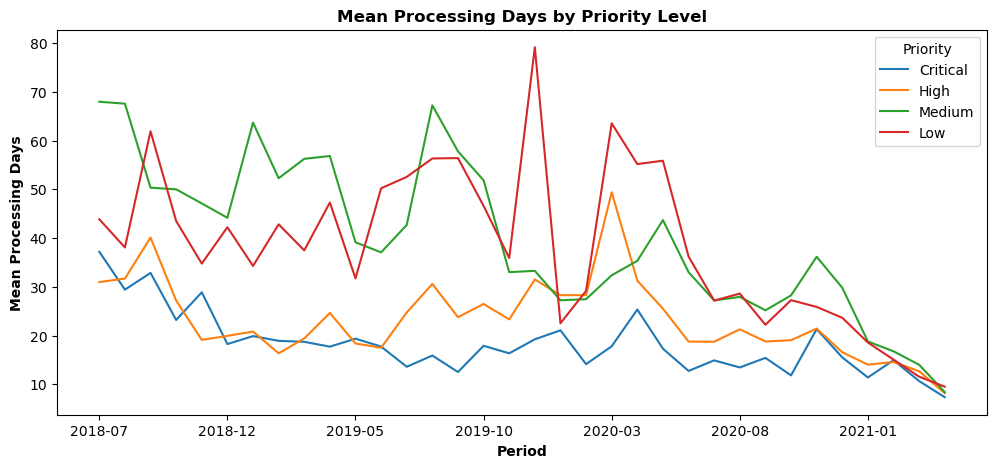

In [32]:
# Group the data by period and issue type and get the mean processing days for each group
grouped_data = data_34.loc[data_34['Resolution'] != 'Open'].groupby(['Period', 'Priority'])['Processing Days'].mean()

# Reshape the data to create a table with the mean processing days for each period and issue type
table_data = grouped_data.unstack(level=-1).reindex(['Critical', 'High', 'Medium', 'Low'], axis=1)

# Create a line plot of the mean processing times for each period and issue type
table_data.plot(kind='line', figsize=(12, 5))

# Add a title and axis labels to the plot
plt.title('Mean Processing Days by Priority Level', fontdict={'weight': 'bold'})
plt.xlabel('Period', fontdict={'weight': 'bold'})
plt.ylabel('Mean Processing Days', fontdict={'weight': 'bold'})

# Display the plot
plt.show()

In [33]:
# Group the data by period and get the mean processing days for each group
grouped_before_17 = data_before_17.loc[(data_before_17['Resolution'] != 'Open') & (data_before_17['Priority'] == 'Critical')].groupby(['Period', 'Priority'])['Processing Days'].mean()
grouped_after_17 = data_after_17.loc[(data_after_17['Resolution'] != 'Open') & (data_after_17['Priority'] == 'Critical')].groupby(['Period', 'Priority'])['Processing Days'].mean()

# Calculate the mean value for each group
mean_before_17 = np.mean(grouped_before_17.values)
mean_after_17 = np.mean(grouped_after_17.values)
change = mean_before_17 - mean_after_17
changepercent = change / (mean_before_17 + mean_after_17) * 100
print(f"The reduction percentage in average processing time after policy implementation; \nCritical:  {change:.2f} days (", changepercent.round(2), "%)")

# Group the data by period and get the mean processing days for each group
grouped_before_17 = data_before_17.loc[(data_before_17['Resolution'] != 'Open') & (data_before_17['Priority'] == 'High')].groupby(['Period', 'Priority'])['Processing Days'].mean()
grouped_after_17 = data_after_17.loc[(data_after_17['Resolution'] != 'Open') & (data_after_17['Priority'] == 'High')].groupby(['Period', 'Priority'])['Processing Days'].mean()

# Calculate the mean value for each group
mean_before_17 = np.mean(grouped_before_17.values)
mean_after_17 = np.mean(grouped_after_17.values)
change = mean_before_17 - mean_after_17
changepercent = change / (mean_before_17 + mean_after_17) * 100
print(f"High:  {change:.2f} days (", changepercent.round(2), "%)")

# Group the data by period and get the mean processing days for each group
grouped_before_17 = data_before_17.loc[(data_before_17['Resolution'] != 'Open') & (data_before_17['Priority'] == 'Medium')].groupby(['Period', 'Priority'])['Processing Days'].mean()
grouped_after_17 = data_after_17.loc[(data_after_17['Resolution'] != 'Open') & (data_after_17['Priority'] == 'Medium')].groupby(['Period', 'Priority'])['Processing Days'].mean()

# Calculate the mean value for each group
mean_before_17 = np.mean(grouped_before_17.values)
mean_after_17 = np.mean(grouped_after_17.values)
change = mean_before_17 - mean_after_17
changepercent = change / (mean_before_17 + mean_after_17) * 100
print(f"Medium:  {change:.2f} days (", changepercent.round(2), "%)")

# Group the data by period and get the mean processing days for each group
grouped_before_17 = data_before_17.loc[(data_before_17['Resolution'] != 'Open') & (data_before_17['Priority'] == 'Low')].groupby(['Period', 'Priority'])['Processing Days'].mean()
grouped_after_17 = data_after_17.loc[(data_after_17['Resolution'] != 'Open') & (data_after_17['Priority'] == 'Low')].groupby(['Period', 'Priority'])['Processing Days'].mean()

# Calculate the mean value for each group
mean_before_17 = np.mean(grouped_before_17.values)
mean_after_17 = np.mean(grouped_after_17.values)
change = mean_before_17 - mean_after_17
changepercent = change / (mean_before_17 + mean_after_17) * 100
print(f"Low:  {change:.2f} days (", changepercent.round(2), "%)")

The reduction percentage in average processing time after policy implementation; 
Critical:  5.53 days ( 15.09 %)
High:  2.16 days ( 4.62 %)
Medium:  24.72 days ( 31.13 %)
Low:  12.05 days ( 15.67 %)


To understand how the policy had affected the completion of projects, a box plot was created to visualize the distribution. The box plot revealed that there were no outliers, indicating the varience of project duration was within the range of acceptance. 

Generally, the duration taken for each project after policy implementation was drastically reduced by an estimated of 40% based on the max range, and the first quartile, median and third quartile were lowered as compared to the project duration before policy implemntation. It is a clear indication that the policy was effective in reducting the project completion duration.

The policy is beneficial to SmartLoan for a more efficient and improved performance.


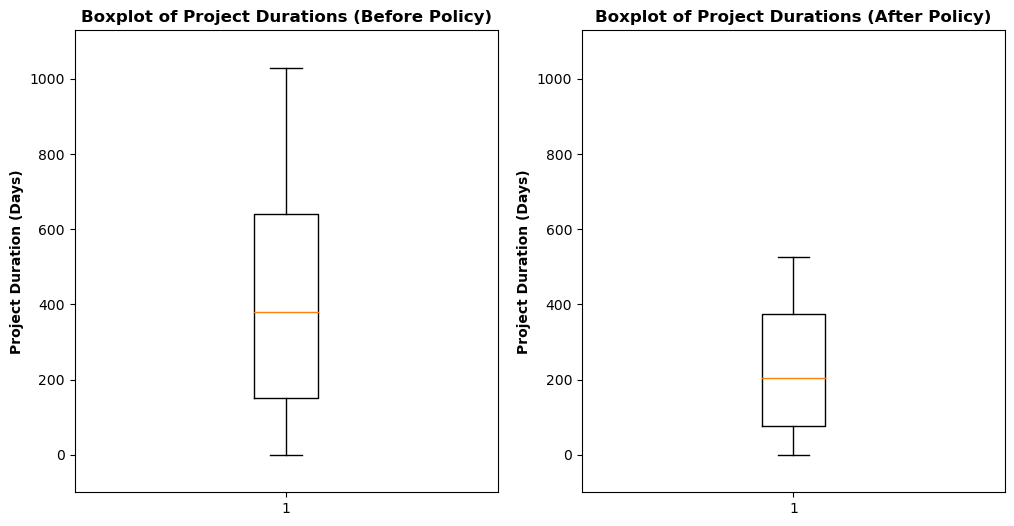

In [34]:
# Group the data by project and get the first issue occurrence date and the last resolved date and count of issues for each period
grouped_data_before = data_before_17.loc[data_before_17['Resolution'] != 'Open'].groupby('Project Name').agg({'Created Date': 'min', 'Resolved Date': 'max', 'ID': 'count'})
grouped_data_after = data_after_17.loc[data_after_17['Resolution'] != 'Open'].groupby('Project Name').agg({'Created Date': 'min', 'Resolved Date': 'max', 'ID': 'count'})

# Rename issue count column
grouped_data_before = grouped_data_before.rename(columns={'ID':'Issue Count (Before)'})
grouped_data_after = grouped_data_after.rename(columns={'ID':'Issue Count (After)'})

# Calculate the project duration as the difference between the last resolved date and the first issue occurrence date for each period
grouped_data_before['Project Duration (Days)'] = (grouped_data_before['Resolved Date'] - grouped_data_before['Created Date']).dt.days
grouped_data_after['Project Duration (Days)'] = (grouped_data_after['Resolved Date'] - grouped_data_after['Created Date']).dt.days

# Get the maximum project duration for each period and set the y-axis limit to be the same for both subplots
max_duration = max(grouped_data_before['Project Duration (Days)'].max(), grouped_data_after['Project Duration (Days)'].max()) +100

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# Create boxplots of project duration for each period and display them side by side
ax[0].boxplot(grouped_data_before['Project Duration (Days)'])
ax[1].boxplot(grouped_data_after['Project Duration (Days)'])

# Set the y-axis limits to be the same for both subplots
ax[0].set_ylim([-100, max_duration])
ax[1].set_ylim([-100, max_duration])

# Add titles and axis labels to the plots
ax[0].set_title('Boxplot of Project Durations (Before Policy)', fontdict={'weight': 'bold'})
ax[1].set_title('Boxplot of Project Durations (After Policy)', fontdict={'weight': 'bold'})
ax[0].set_ylabel('Project Duration (Days)', fontdict={'weight': 'bold'})
ax[1].set_ylabel('Project Duration (Days)', fontdict={'weight': 'bold'})

# Display the plot
plt.show()

# **Time Series Forecasting**

Forecasting the number of issues will provide valuable insights to the management on resource planning. The data for 17 months post policy will be used to train and test the time sereies model since the policy was concluded to be effective. The focus on the data post policy implementation ensures the accuracy and reliability of the time series model for future forecasting and decision-making. Utilizing the data pre policy implementation will not be an accurate representation.

# **ARIMA (Daily)**

There is 17 months post policy implementation data. The first 14 months shall be used as train set to build the ARIMA model and the subsequent months as test set for testing the model's accuracy.

Considering a possibility of a seasonal cycle, and other potential factors that may affect the data, a minimum of 2 cycles (24 months) is recommended to train the ARIMA model.

An ARIMA model was tested on a monthly basis, which was not able to produce a desirable prediction, a daily model will be used to bulid the ARIMA model.

In [35]:
# Subset the data to relevant columns and set 'Period' as index
timeseries = data_after_17.groupby('Created Date')['ID'].count()

# Convert the index to a datetime object
timeseries.index = pd.to_datetime(timeseries.index)

# Resample the time series to a monthly frequency and fill missing values with 0
timeseries = timeseries.resample('D').sum().fillna(0)

# Split the data into train and test sets
train = timeseries.loc['2019-12-01':'2021-01-31']
test = timeseries.loc['2021-02-01':'2021-04-30']

# Stationarity Check

The first requirement, for an accurate ARIMA model building, is the stationarity of the dataset. The method used will be;
1. Time series plot
2. Augmented Dickey-Fuller (ADF) Test
3. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

Should the time series fail to be stationary, differencing of the data is required till stationarity is achieved.

**Time Series Plot**

The visual inspection of the plot does not show an increasing or decreasing trend. Furthermore, both rolling mean and standard deviateion did not detect the trend. Nontheless, differencing is required as the time series data did not roam around a defined mean and is not constant over team.

Furthermore, the time series data fluatates up and down in close frequency suggesting a seasonal component. The ACF plot reflected seasonal pattern of significant spike every 7 lags. The data requires differencing to remove the seasonality component in the data.


**Augmented Dickey-Fuller (ADF) Test**
* Null Hypothesis: Data is not stationary
* Alternative Hypothesis: Data is stationary

With a ADF statistic of -0.2671241 and p-value of 0.079148, it failed to reject the null hypothesis, suggesting that the train series is non stationary. The ADF statistic is higher than the critical value at 5% but lower at 1%. Hence, the null hypothesis is rejected at significance level of 5% but cannot be rejected at 10% signifiance level.

**Kwiatkowski-Phillips-Schmidt-Shin Test**

* Null Hypothesis: Data is trend stationary
* Alternative Hypothesis: Data is not trend stationary

KPSS statistic of 0.1938607944930736 is greater than the critical value at 2.5%. The null hypothesis of trend staionarity is rejected at 2.5% significant level. Hence, the time series is not trend staionary at 95% confidence. Differencing is required to make the time series stationary.

Conclusion: Train series is non stationary, differencing is required before time series model.

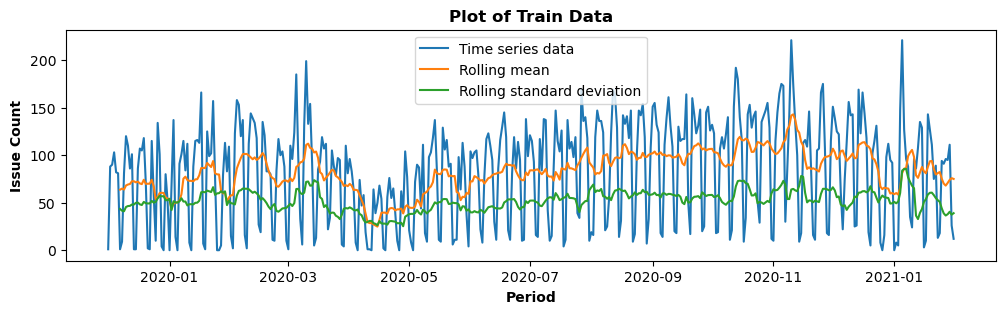

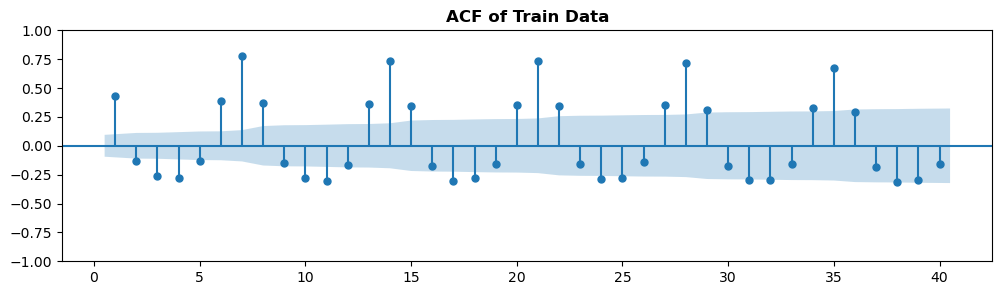


Train Data stationarity check

ADF Statistic: -2.671241
n_lags: 0.07914843201892868
p-value: 0.079148
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571
KPSS Statistic: 0.1938607944930736
p-value: 0.018302202065097393
Critical Values:
	10%%: 0.119
	5%%: 0.146
	2.5%%: 0.176
	1%%: 0.216


In [36]:
# Calculate the rolling mean and standard deviation with a window size of 7
rolling_mean = train.rolling(window=7).mean()
rolling_std = train.rolling(window=7).std()

# Plot the time series data and rolling statistics
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(train.index, train, label='Time series data')
plt.plot(rolling_mean.index, rolling_mean, label='Rolling mean')
plt.plot(rolling_std.index, rolling_std, label='Rolling standard deviation')
plt.title('Plot of Train Data', fontdict={'weight': 'bold'})
plt.xlabel('Period', fontdict={'weight': 'bold'})
plt.ylabel('Issue Count', fontdict={'weight': 'bold'})
plt.legend(loc='best')
plt.show()

# Plot the ACF of train dataset
fig, ax = plt.subplots(figsize=(12, 3))
sm.graphics.tsa.plot_acf(train.dropna(), lags=40, ax=ax, zero=False)
ax.set_title('ACF of Train Data', fontdict={'weight': 'bold'})
plt.show()

# Conduct ADF test on train dataset
result = adfuller(train, autolag='AIC')

# Print ADF test statistics
print('\033[1;4;33m' +  '\nTrain Data stationarity check\n' + '\033[0m')
print('ADF Statistic: %f' % result[0])
print(f'n_lags: {result[1]}')
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Perform KPSS test on train dataset
kpss_test = kpss(train, regression='ct', nlags="auto")
print('KPSS Statistic:', kpss_test[0])
print('p-value:', kpss_test[1])
print('Critical Values:')
for key, value in kpss_test[3].items():
    print(f'\t{key}%: {value}')

**1st and 2nd differencing**

**Time Series Plot**

After first and second differencing was completed, the time series data fluctuates around zero. This itself suggestes that the mean of the time series has been removed and the series is now stationary. There isn't much change to the rolling mean and standard deviation, except that it had flatten with every differencing. Both plot exhibits seasonality behaviour.

**Augmented Dickey-Fuller (ADF) Test**
ADF Statistic: -6.814636
p-value: 0.000000
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571
KPSS Statistic: 0.23253582432481415
p-value: 0.1
Critical Values:
	10%%: 0.347
	5%%: 0.463
	2.5%%: 0.574
	1%%: 0.739
* Null Hypothesis: Data is not stationary
* Alternative Hypothesis: Data is stationary

With a ADF statistic of -6.814636 and p-value of 0.000000, the null hypothesis is rejected, suggesting that the train time series is stationary. The ADF statistic is lower than all the critical value of 1% , 5% and 10%. 

**Kwiatkowski-Phillips-Schmidt-Shin Test**

* Null Hypothesis: Data is trend stationary
* Alternative Hypothesis: Data is not trend stationary

KPSS statistic of 0.23253582432481415, and p-value of 0.1, the KPSS test failed to reject the null hypothesis. The KPSS statistic is lower than all critcal values, the null hypothesis is not rejected and the data is trend stationary.

Conclusion: To avoid the possiblity of over-differencing, 1st differencing is sufficient to proceed with the modeling. Nonetheless, note that there might be seasonality component in the time series.

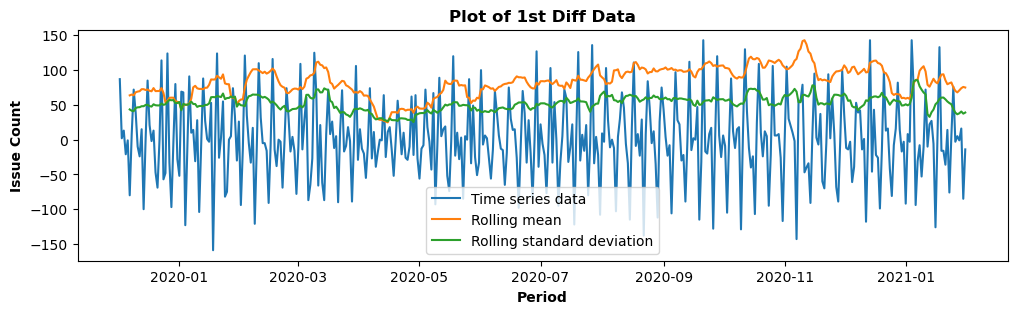

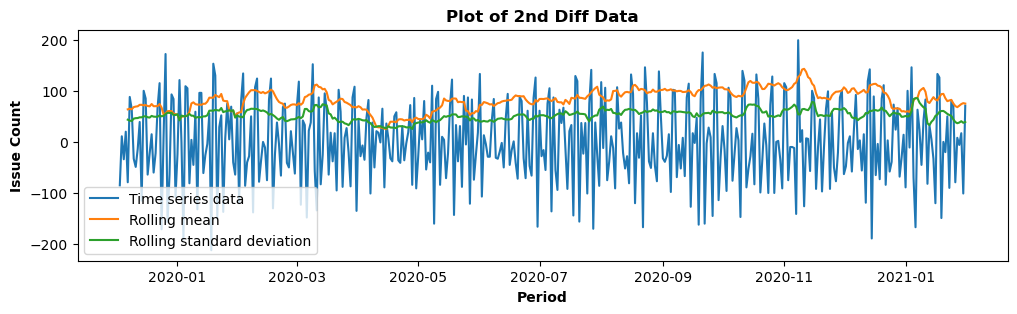


1st differencing stationarity check

ADF Statistic: -6.814636
n_lags: 2.074138465451969e-09
p-value: 0.000000
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571
KPSS Statistic: 0.23253582432481415
n_lags: 0.1
p-value: 0.1
Critical Values:
	10%%: 0.347
	5%%: 0.463
	2.5%%: 0.574
	1%%: 0.739

2nd differencing stationarity check

ADF Statistic: -7.508233
n_lags: 4.080423457356648e-11
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
KPSS Statistic: 0.09134904009116905
n_lags: 0.1
p-value: 0.1
Critical Values:
	10%%: 0.347
	5%%: 0.463
	2.5%%: 0.574
	1%%: 0.739
The sample size for train data:  428


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [37]:
# 1st differencing to train dataset
diff_train = train.diff()
diff_train.dropna(inplace=True)

# 2nd differencing to train dataset
diff_diff_train = train.diff().diff()
diff_diff_train.dropna(inplace=True)

# Calculate the rolling mean and standard deviation with a window size of 7
first_rolling_mean = diff_train.rolling(window=7).mean()
first_rolling_std = diff_train.rolling(window=7).std()

# Plot the time series data and rolling statistics
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(diff_train.index, diff_train, label='Time series data')
plt.plot(rolling_mean.index, rolling_mean, label='Rolling mean')
plt.plot(rolling_std.index, rolling_std, label='Rolling standard deviation')
plt.title('Plot of 1st Diff Data', fontdict={'weight': 'bold'})
plt.xlabel('Period', fontdict={'weight': 'bold'})
plt.ylabel('Issue Count', fontdict={'weight': 'bold'})
plt.legend(loc='best')
plt.show()

# Calculate the rolling mean and standard deviation with a window size of 7
second_rolling_mean = diff_diff_train.rolling(window=7).mean()
second_rolling_std = diff_diff_train.rolling(window=7).std()

# Plot the time series data and rolling statistics
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(diff_diff_train.index, diff_diff_train, label='Time series data')
plt.plot(rolling_mean.index, rolling_mean, label='Rolling mean')
plt.plot(rolling_std.index, rolling_std, label='Rolling standard deviation')
plt.title('Plot of 2nd Diff Data', fontdict={'weight': 'bold'})
plt.xlabel('Period', fontdict={'weight': 'bold'})
plt.ylabel('Issue Count', fontdict={'weight': 'bold'})
plt.legend(loc='best')
plt.show()

# Conduct ADF test on 1st differencing dataset
diff_adf_result = adfuller(diff_train, autolag='AIC')

# Perform ADF test on 1st differencing dataset
print('\033[1;4;33m' +  '\n1st differencing stationarity check\n' + '\033[0m')
print('ADF Statistic: %f' % diff_adf_result[0])
print(f'n_lags: {diff_adf_result[1]}')
print('p-value: %f' % diff_adf_result[1])
print('Critical Values:')
for key, value in diff_adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Perform KPSS test on 1st differencing dataset
diff_kpss_result = kpss(diff_train, regression='c', nlags="auto")
print('KPSS Statistic:', diff_kpss_result[0])
print(f'n_lags: {diff_kpss_result[1]}')
print('p-value:', diff_kpss_result[1])
print('Critical Values:')
for key, value in diff_kpss_result[3].items():
    print(f'\t{key}%: {value}')
    
# Conduct ADF test on 2nd differencing dataset
diff_diff_adf_result = adfuller(diff_diff_train, autolag='AIC')

# Perform ADF test on 2nd differencing dataset
print('\033[1;4;33m' +  '\n2nd differencing stationarity check\n' + '\033[0m')
print('ADF Statistic: %f' % diff_diff_adf_result[0])
print(f'n_lags: {diff_diff_adf_result[1]}')
print('p-value: %f' % diff_diff_adf_result[1])
print('Critical Values:')
for key, value in diff_diff_adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Perform KPSS test on 2nd differencing dataset
diff_diff_kpss_result = kpss(diff_diff_train, regression='c', nlags="auto")
print('KPSS Statistic:', diff_diff_kpss_result[0])
print(f'n_lags: {diff_diff_kpss_result[1]}')
print('p-value:', diff_diff_kpss_result[1])
print('Critical Values:')
for key, value in diff_diff_kpss_result[3].items():
    print(f'\t{key}%: {value}')

print('The sample size for train data: ', train.shape[0])

**Final Determination of Seasonality Component**

As seen from the ACF plots for Train time series and the plots after first and second differencing, there are seasonality component present. The spikes are falling into a 7 lags cycle, indicating a correlation between the observations that are 7 lags apart, representing a weekly cycle.

The time series will have to undergo seasonal decomposition before fitting an ARIMA.

**Values of (p,d,q)**

d = 1 regular differencing

p = 6 as the last significant lag of the PACF

q = there is seasonality in ACF, hence it will be determined from the residual ACF plot after seasonal decomposition.

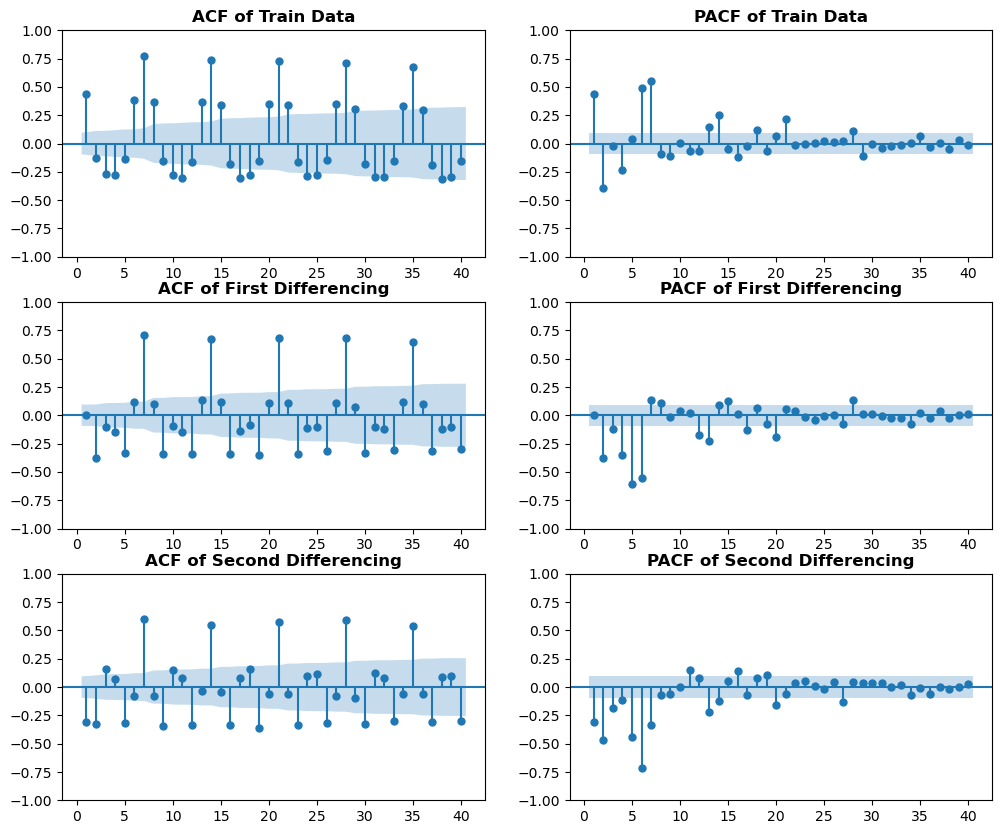

In [38]:
# Create a figure with 3 rows and 2 columns of subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Plot the ACF and PACF of the original series in the first row
sm.graphics.tsa.plot_acf(train.dropna(), lags=40, ax=axs[0, 0], zero=False)
sm.graphics.tsa.plot_pacf(train.dropna(), lags=40, ax=axs[0, 1], zero=False, method='ywm')
axs[0, 0].set_title('ACF of Train Data', fontdict={'weight': 'bold'})
axs[0, 1].set_title('PACF of Train Data', fontdict={'weight': 'bold'})

# Plot the ACF and PACF of the first difference in the second row
sm.graphics.tsa.plot_acf(diff_train, lags=40, ax=axs[1, 0], zero=False)
sm.graphics.tsa.plot_pacf(diff_train, lags=40, ax=axs[1, 1], zero=False, method='ywm')
axs[1, 0].set_title('ACF of First Differencing', fontdict={'weight': 'bold'})
axs[1, 1].set_title('PACF of First Differencing', fontdict={'weight': 'bold'})

# Plot the ACF and PACF of the second difference in the third row
sm.graphics.tsa.plot_acf(diff_diff_train, lags=40, ax=axs[2, 0], zero=False)
sm.graphics.tsa.plot_pacf(diff_diff_train, lags=40, ax=axs[2, 1], zero=False, method='ywm')
axs[2, 0].set_title('ACF of Second Differencing', fontdict={'weight': 'bold'})
axs[2, 1].set_title('PACF of Second Differencing', fontdict={'weight': 'bold'})

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2)

# Display the plot
plt.show()

# SARIMA

In order to proceed with a fitting to SARIMA, the train time series will have to undergo seasonal decomposition.

1. Original data plot: As per comparison earlier, the time series data fluctuates around zero after regular differencing had been done on the timeseries.
2. Trend component: After first seasonal decomposition, there is no distinct trend and it fluctuates along zero.
3. Seasonal component: There is repeating pattern on a weekly basis indicating seasonality component in both seasonal decomposition plot.
4. Residual component: Plots shows random pattern of the residual after removing trend and seasonality. There are no remaning correlation or pattern found in oth decomposition plot

Conclusion: First seasonal decomposition will be used for the fitting of SARIMA model.


First Seasonal Decomposition for 1st Differencing Train Dataset


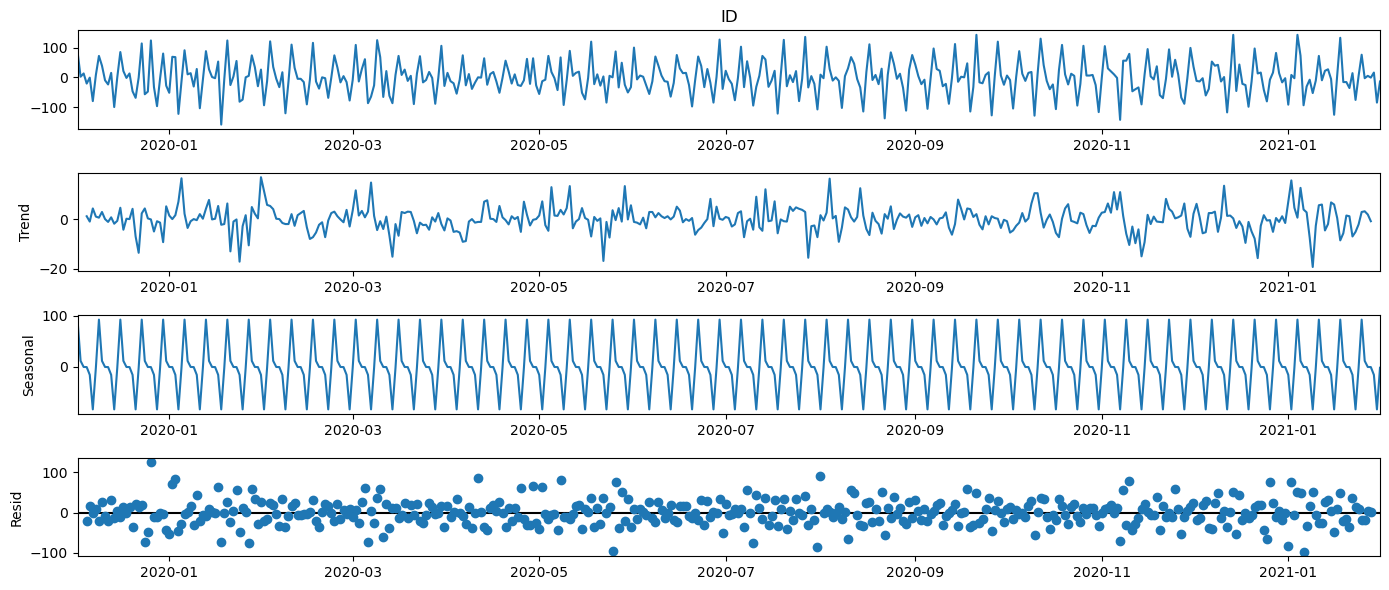


Second Seasonal Decomposition for 1st Differencing Train Dataset


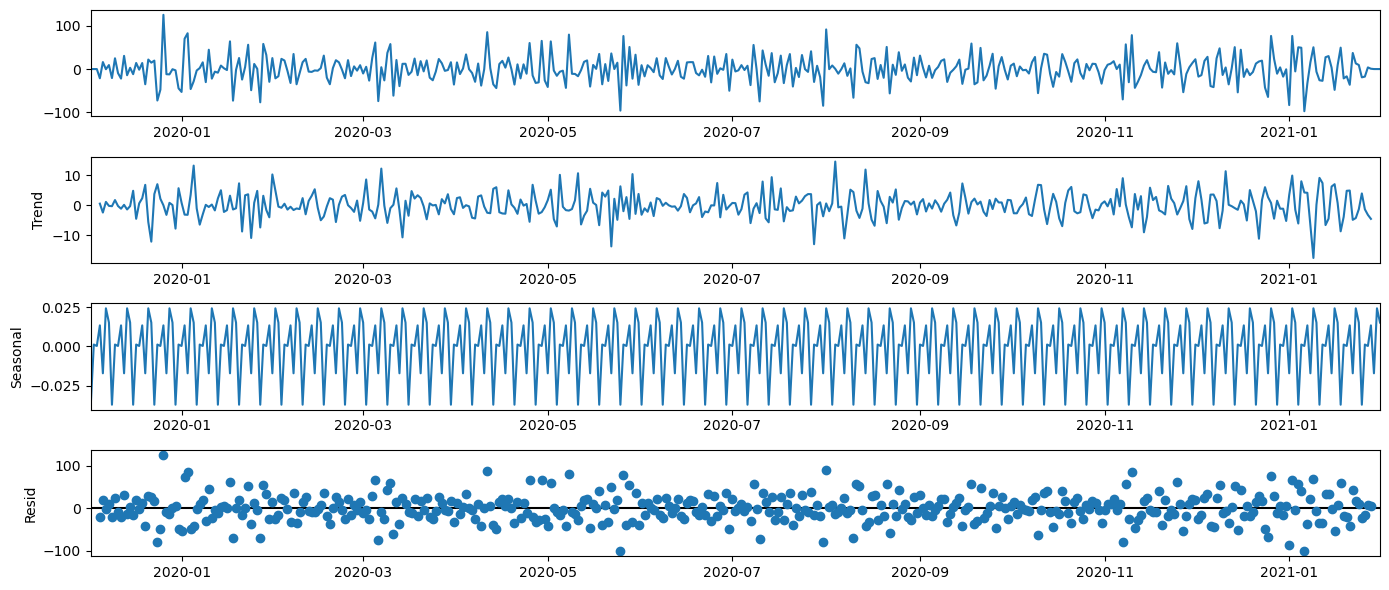

In [39]:
rcParams['figure.figsize'] = 14, 6

# Seasonal decomposition of 1st differencing train time series
s_diff_train = sm.tsa.seasonal_decompose(diff_train, model='additive')
fig = s_diff_train.plot()

# Display plot
print("\nFirst Seasonal Decomposition for 1st Differencing Train Dataset")
plt.show()

# Compute residuals from 1st Seasonal decomposition
residuals = diff_train - s_diff_train.seasonal - s_diff_train.trend

# Check for missing values in the input data
if residuals.isna().any():
    # Impute missing values with mean
    residuals = residuals.fillna(residuals.mean())

# Perform second seasonal decomposition on the data with missing values imputed
s_diff_train2 = sm.tsa.seasonal_decompose(residuals, model='additive', period=7)
fig2 = s_diff_train2.plot()
print("\nSecond Seasonal Decomposition for 1st Differencing Train Dataset")
plt.show()

**Values of (p,d,q)**

d = 1 regular differencing

p = 6 as the last significant lag of the PACF

q = 2 as the last significant lag of the ACF of residuals

**Values of (P,D,Q)**

D = 1 seasonal decomposition

P = 9 as the last significant lag of the PACF

Q = 2 as the last significant lag of the ACF

The final model, SARIMA(6,1,2),(9,1,2)7, was decided based on the analysis of the PACF and ACF plots, capturing the weekly seasonality and trend in the data to make accurate predictions.

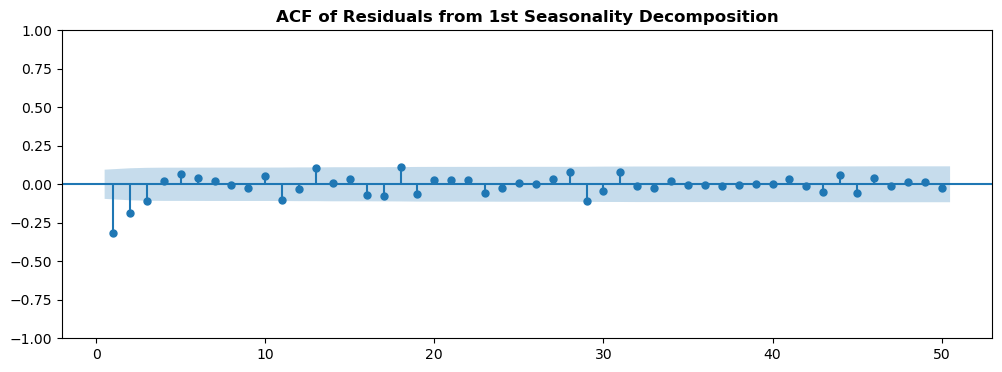

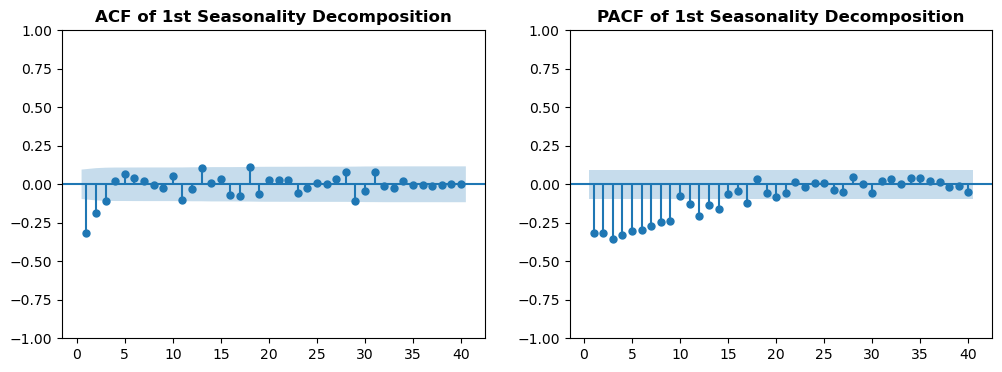

In [40]:
# Plot ACF of residuals to determine value of q
fig, ax = plt.subplots(figsize=(12,4))
plot_acf(residuals, lags=50, ax=ax, zero=False)
plt.title('ACF of Residuals from 1st Seasonality Decomposition', fontdict={'weight': 'bold'})
plt.show()

# Create a figure with 3 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the ACF and PACF of the first difference in the second row
s_diff_train_resid = s_diff_train.resid
sm.graphics.tsa.plot_acf(s_diff_train_resid.dropna(), lags=40, ax=axs.ravel()[0], zero=False)
sm.graphics.tsa.plot_pacf(s_diff_train_resid.dropna(), lags=40, ax=axs.ravel()[1], zero=False, method='ywm')
axs.ravel()[0].set_title('ACF of 1st Seasonality Decomposition', fontdict={'weight': 'bold'})
axs.ravel()[1].set_title('PACF of 1st Seasonality Decomposition', fontdict={'weight': 'bold'})

# Display the plot
plt.show()

# **Time Series Model Fitting**
Although the final model was determined as SARIMA(6,1,2)(9,1,2)7, it did not return with all coefficients of p-value less than 0.05. After iteration, SARIMA(3,1,3)(4,1,0)7 was able to fulfill p-value less than 0.05 for all coefficients. SARIMAX(2,1,3) was also derived from auto-arima to achieve p-value less than 0.05 for all coefficients. However, SARIMA(6,1,2)(9,1,2)7 had the lowest AIC of 3979.402 while the other 2 models are of 4006.341 and 4267.034 respectively. On top of that, it had the best fit plots for model diagnostics.

Ideally, having all coefficients with p-values less than 0.05 proves that the variables are statistically significant and produces a more reliable model. On the other hand, other factors like the AIC, indicating a better fit of the model and model diagonostics reflecting model capturing of patterns and residuals are as important as a considering factor.

The most appropriate mode is SARIMA(6,1,2)(9,1,2)7.

SARIMA(6,1,2),(9,1,2)7 was fitted to the train model and it had derived an AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) of 3979.402 and 4060.207 respectively.


* Null Hypothesis: The residuals are independently distributed
* Alternate Hypothesis: The residuals are not independently distributed; they exhibit serial correlation

The Ljung-Box (L1)(Q) Prob (Q) is 0.03 and the p-value is 0.86. Since the probability is above 0.05, the null hypothesis is not rejected, the residuals for the time series are white noise.

* Null Hypothesis: The residuals are uniformly scattered
* Alternate Hypothesis: The residuals are not uniformly scattered

Heteroskedasticity is reported as 0.99 with p-value of 0.97 which failed to reject the null hypothesis. The residuals are random.

This was also reflected in the standardized residual plot whereby there is no trend.
In the histogram plus estimated density, there is a normal distribution of the histogram and N(0,1) line. Both histogram (green) line and the density (orange) line matches. The data is well-representated.

The Normal Q-Q had majority of points lie close to the straight line following a normal distribution, except for the lower end. This was reflected in the fitted ARIMA results where Kurtosis was 4.40 representing that the is heavier at the tail.

A flat correlogram suggest the stationarity of the time series, which was established earlier.

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                    SARIMAX Results                                    
Dep. Variable:                              ID   No. Observations:                  428
Model:             ARIMA(6, 1, 2)x(9, 1, 2, 7)   Log Likelihood               -1969.701
Date:                         Mon, 08 May 2023   AIC                           3979.402
Time:                                 04:30:05   BIC                           4060.207
Sample:                             12-01-2019   HQIC                          4011.339
                                  - 01-31-2021                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5688      0.187     -3.039      0.002      -0.936      -0.202
ar.L2          0.3304      0.089      3.701      0.000     

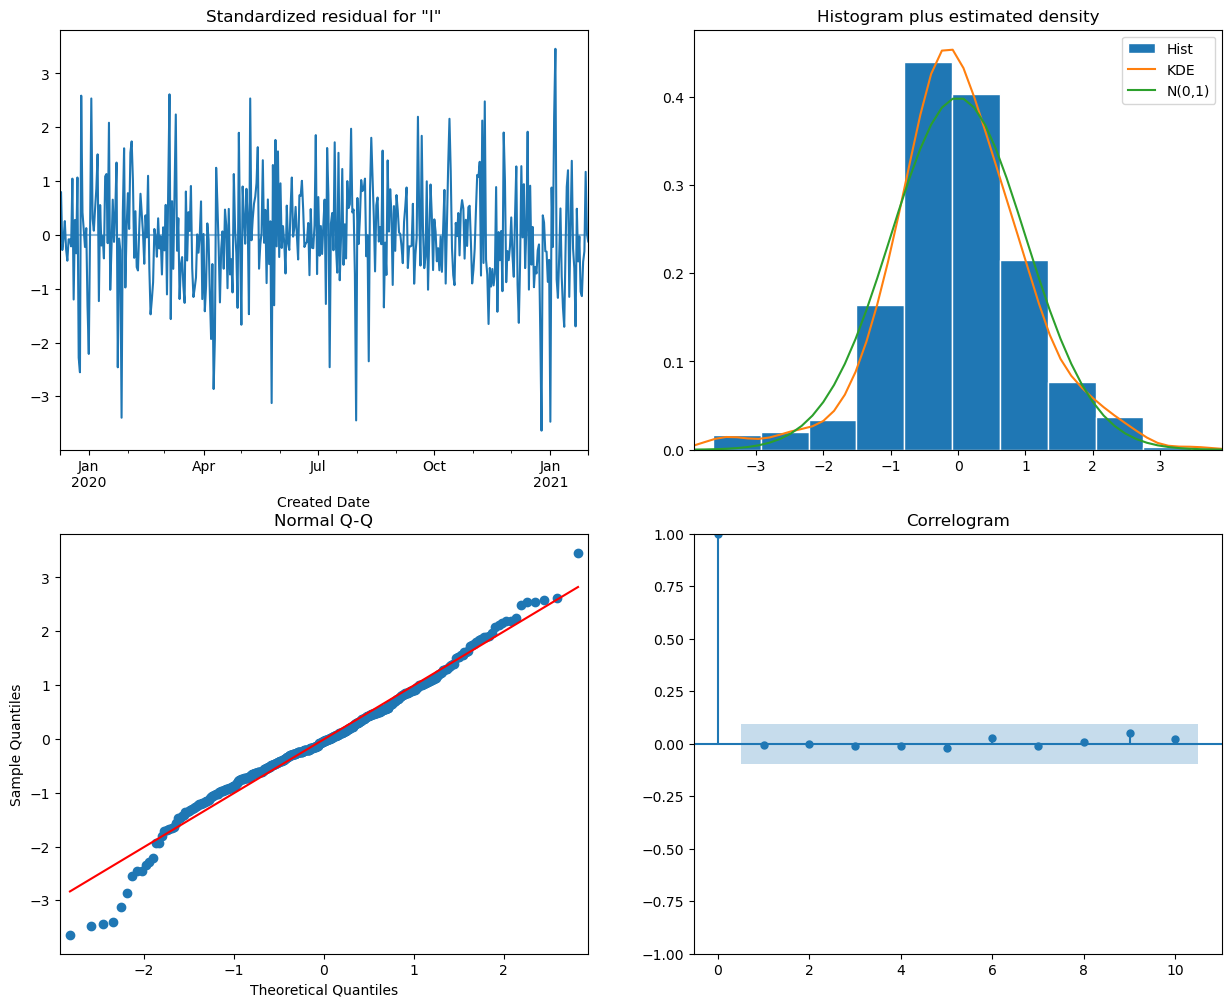

In [41]:
# Fit an SARIMA(6,1,2),(9,1,2)7 to model to the training data
sarima_model = ARIMA(train, order=(6, 1, 2), seasonal_order=(9,1,2,7))
sarima_model_fit = sarima_model.fit()

# Print the model summary
print(sarima_model_fit.summary())

# run model diagnostics
sarima_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                    SARIMAX Results                                     
Dep. Variable:                               ID   No. Observations:                  428
Model:             ARIMA(3, 1, 3)x(4, 1, [], 7)   Log Likelihood               -1992.170
Date:                          Mon, 08 May 2023   AIC                           4006.341
Time:                                  04:30:20   BIC                           4050.784
Sample:                              12-01-2019   HQIC                          4023.907
                                   - 01-31-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4718      0.057    -25.848      0.000      -1.583      -1.360
ar.L2         -0.3708      0.080     -4.639      0.

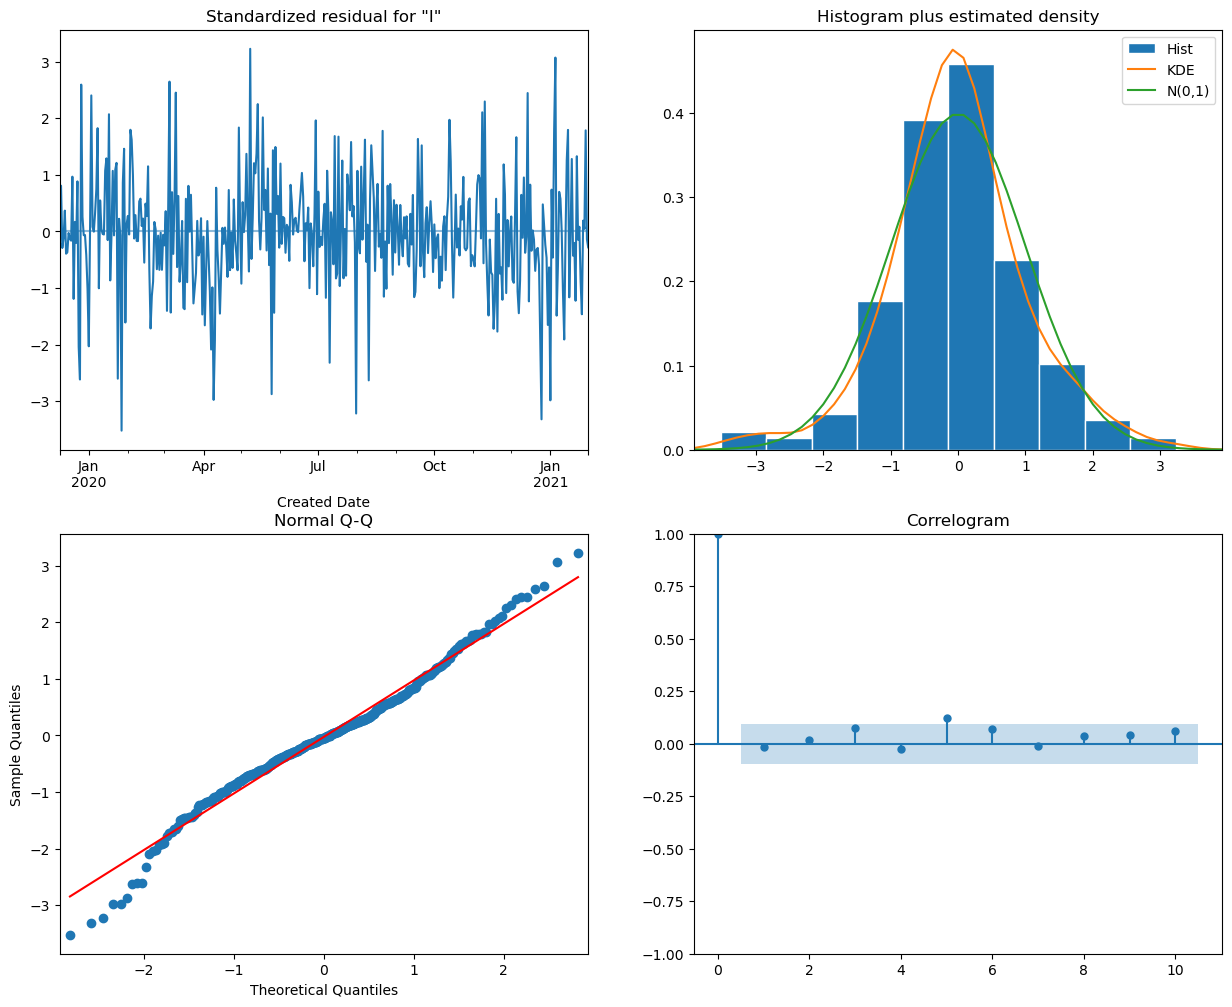

In [42]:
# Fit an SARIMA(3,1,3),(4,1,0)7 to model to the training data
sarima__model = ARIMA(train, order=(3, 1, 3), seasonal_order=(4,1,0,7))
sarima__model_fit = sarima__model.fit()
print(sarima__model_fit.summary())

# run model diagnostics
sarima__model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  428
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -2127.517
Date:                Mon, 08 May 2023   AIC                           4267.034
Time:                        04:30:38   BIC                           4291.375
Sample:                    12-01-2019   HQIC                          4276.648
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2454      0.002    533.967      0.000       1.241       1.250
ar.L2         -0.9981      0.002   -433.371      0.000      -1.003      -0.994
ma.L1         -2.1599      0.028    -78.068      0.0

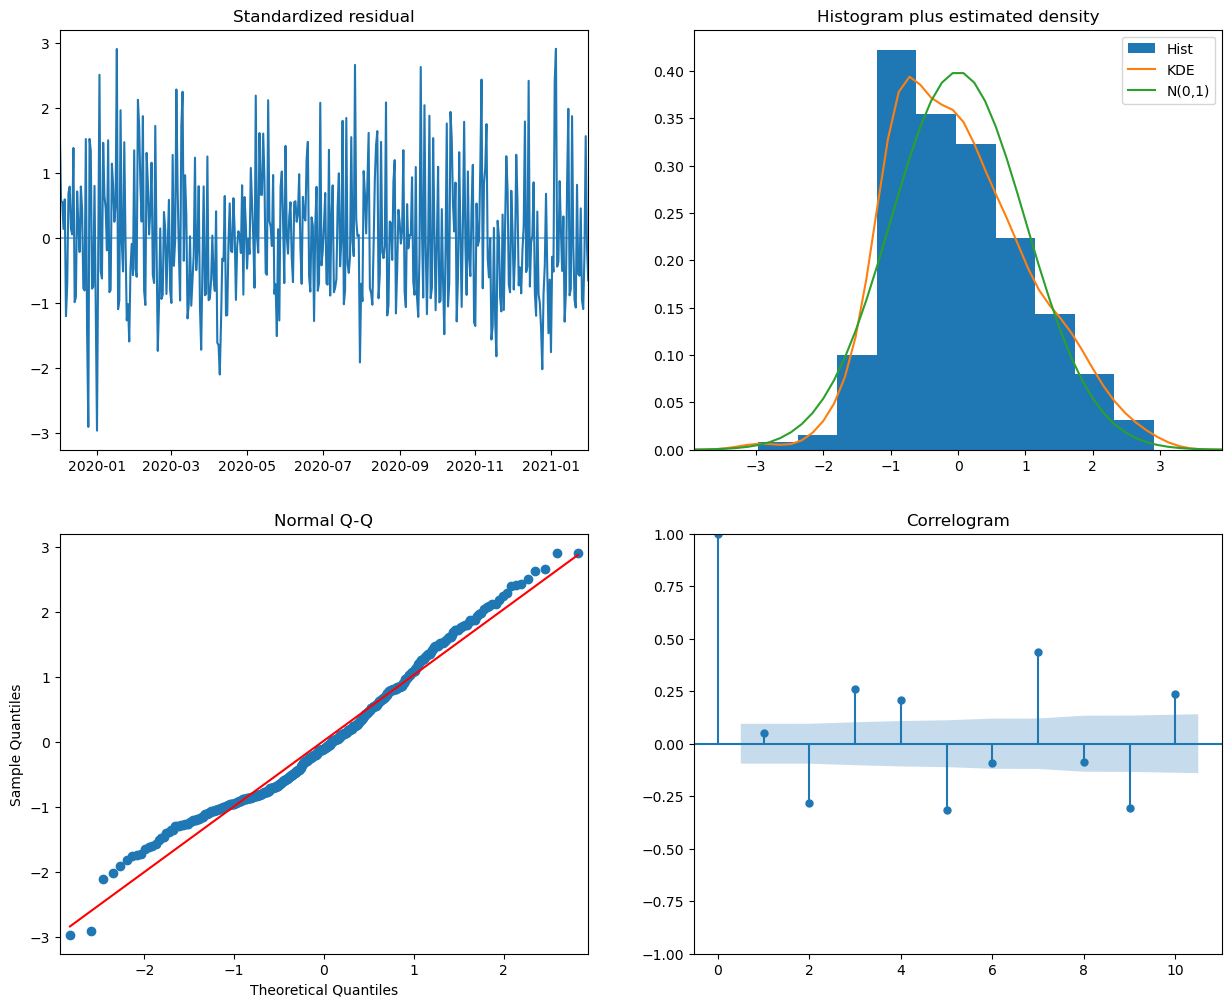

In [43]:
# Fit ARIMA model to train data
auto_model = auto_arima(train, seasonal=True, suppress_warnings=True)

# Print the summary of the model
print(auto_model.summary())

# run model diagnostics
auto_model.plot_diagnostics(figsize=(15, 12))
plt.show()

# **Fitting Model to Test Data**
Fitting the model SARIMA(6,1,2)(9,1,2)7 to predict the test dataset will allow an evaluation into the performance of the model on the untrain test dataset. The forecasted data for the next 89 days (3 months) using the trained model resulted in a mean absolute error of 20.16 between the mean of predicted and actual values. The plot of Predicted Values Against Actual Values were of the right trend and is close to the actual value, apart for the unexpected peaks.

MAE: 20.16


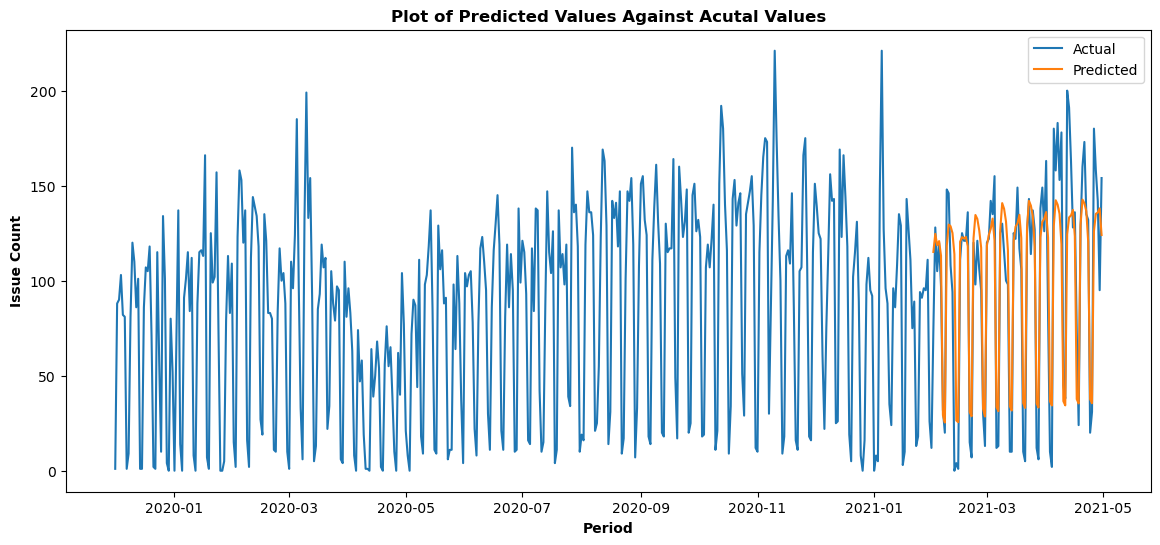

In [44]:
# Fit most appropriate SARIMA(6,1,2),(9,1,2)7 to the training data
final_model = sarima_model
final_model_fit = sarima_model_fit

# Generate the forecast to fit test data (89 days)
test_forecast = final_model_fit.predict(start=len(train), end=len(train)+88, alpha=0.05)

# Calculate the MAE between the predicted and actual values
mae = mean_absolute_error(test, test_forecast)

# Print the MAE to the console
print("MAE:", mae.round(2))

# Visualize the predicted and actual values
plt.plot(timeseries, label='Actual')
plt.plot(test_forecast, label='Predicted')
plt.title("Plot of Predicted Values Against Acutal Values", fontdict={'weight': 'bold'})
plt.xlabel('Period', fontdict={'weight': 'bold'})
plt.ylabel('Issue Count', fontdict={'weight': 'bold'})
plt.legend()
plt.show()

# **Forecasting 3 Months of Issues**

Referring to the Business Objective

2. Trend prediction of Issues for next 3 months for resources planning. (Prediction of 3 months is due to the short period available for training data)
    * Will there be an increase or decrease in number of issues?
  
  
The predicted number of issues for the next 3 months sugguest that the values may fluctuate. According to the prediction there will be a 11.42% reduction in May, followed by a 4.47% increase and further increase by 2.72% in June and July respectively. 

The prediction was made using the SARIMA(6, 1, 2)(9, 1, 2,)7, the outcome requires futher fine tuning as the available data model training grows.

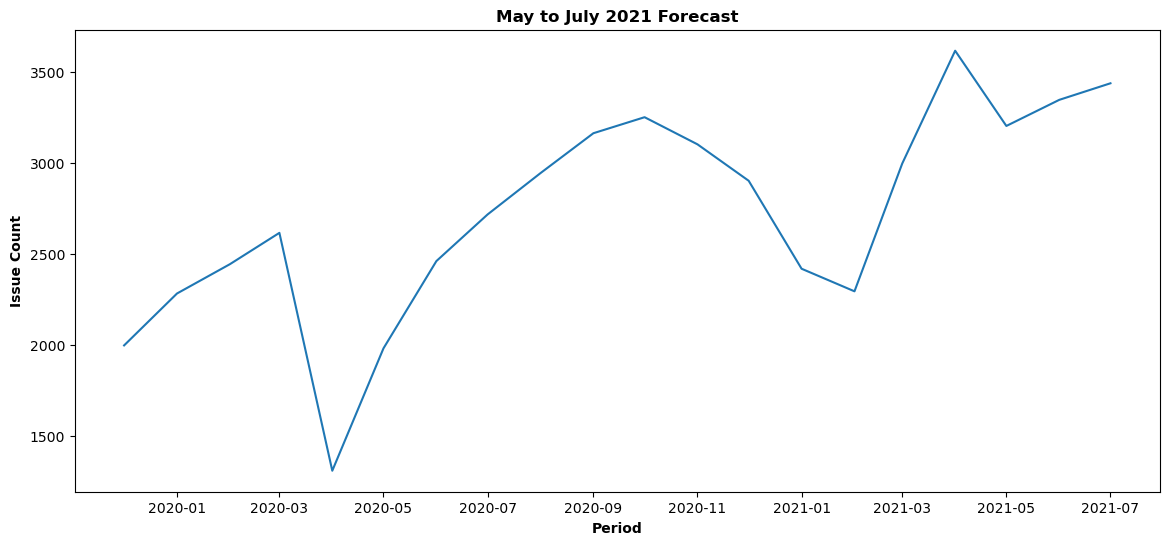

In [45]:
# Predict number of issues from May to July 2021

# Generate the forecast for the next 3 months (92 days)
forecast = final_model_fit.predict(start=len(timeseries), end=len(timeseries)+91)

# Concatenate the two dataframes
result = pd.concat([timeseries, forecast], axis=0, sort=True)

# Group the daily forecast by month and convert to a dataframe
result = result.resample('MS').sum().to_frame(name='value')

# Plot the monthly forecast
plt.plot(result)
plt.title('May to July 2021 Forecast', fontdict={'weight': 'bold'})
plt.xlabel('Period', fontdict={'weight': 'bold'})
plt.ylabel('Issue Count', fontdict={'weight': 'bold'})
plt.show()

In [46]:
# Rename the 'value' column to 'Count of Issues'
result = result.rename(columns={'value': 'Count of Issues'})

# Calculate the percentage change between the current and previous month's values
result['% Change'] = result['Count of Issues'].pct_change() * 100

# Round the 'Count of Issues' column to whole number
result['Count of Issues'] = result['Count of Issues'].astype(int)

# Round the '% Change' column to 2 decimal places
result['% Change'] = result['% Change'].round(2)

# Select rows where the index is between '2021-05-31' and '2021-07-31' (inclusive)
result_selected = result.loc[(result.index >= '2021-04-30') & (result.index <= '2021-07-31')]
print(result_selected)

            Count of Issues  % Change
2021-05-01             3203    -11.42
2021-06-01             3347      4.47
2021-07-01             3438      2.72


# **Conclusion**

The Defects Logging and Detection Policy had resulted in notable improvements in the aspect of number of issues and the processing time taken to resolve them. The policy implementation had successfully reduced the monthly issues by 31.44%, from 3,442 to 2,618 issues.

On top of that, there had been a positive impact on the resolution time spent on each issue. The reduction of resolution time was reduced by 37.10% in processing days. This is a substantial improvement in efficiency to the team as the average resolution time has decreased from 33.46 days to 24.4 days.

Although the policy implementation was proven to be effective, the number of issues for the upcoming months will continue to flucatuate as issues are also determined by the amount of projects happening concurrently. From a resouce planning perspective, the current projection will result in a futher reduction of 11.42% in May, followed by a moderate increase of 4.47% and a slight rise of 2.72% in June and July, respectively.

With SmartLoan continuous improvement on the process, there will be significant impact on the efficieny and productivity, resulting in positive impact to the customers. It is recommended that the policy be regularly reviewed and updated to ensure further improvement in the issues logged and issue resolution time.

In [47]:
data_34.to_csv('data_34.csv',index=False)